<a href="https://colab.research.google.com/github/Ehsan-Roohi/DSMC_Python/blob/main/Relaxation_DSMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow Version: 2.18.0
Numba Version: 0.60.0

--- Running DSMC for T = 200.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
    ... T=200.0K, Step 20000/80000 completed ...
    ... T=200.0K, Step 40000/80000 completed ...
    ... T=200.0K, Step 60000/80000 completed ...
    ... T=200.0K, Step 80000/80000 completed ...
DSMC for T = 200.0 K finished. Collected 400010000 samples.

--- Running DSMC for T = 275.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
    ... T=275.0K, Step 20000/80000 completed ...
    ... T=275.0K, Step 40000/80000 completed ...
    ... T=275.0K, Step 60000/80000 completed ...
    ... T=275.0K, Step 80000/80000 completed ...
DSMC for T = 275.0 K finished. Collected 400010000 samples.

--- Running DSMC for T = 350.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
    ... T=350.0K, Step 20000/80000 completed ...
    ... T=350.0K, Step 40000/80000 completed ...
    ... T=350.0K, Step 

Model: "Final_DNN_GPU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 494,337 (1.89 MB)

 Trainable params: 494,337 (1.89 MB)

 Non-trainable params: 0 (0.00 B)


Created tf.data pipelines with batch size 1024.

Starting final model training (GPU Optimized)...
Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.3075 - val_loss: 0.1424
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1486 - val_loss: 0.0840
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0761 - val_loss: 0.0901
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0740 - val_loss: 0.0927
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0751 - val_loss: 0.0850
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0667 - val_loss: 0.0697
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0553 - val_loss: 0.0509
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0421 - val_loss: 0.0386
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0343 - val_loss: 0.0337
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0319 - val_loss: 0.0307
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 

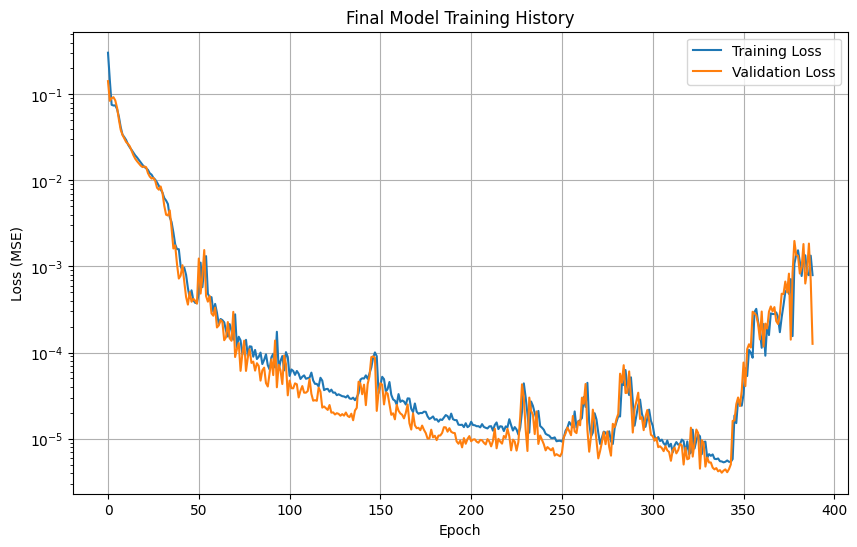


--- Final Model Prediction for an UNSEEN temperature (325 K) ---


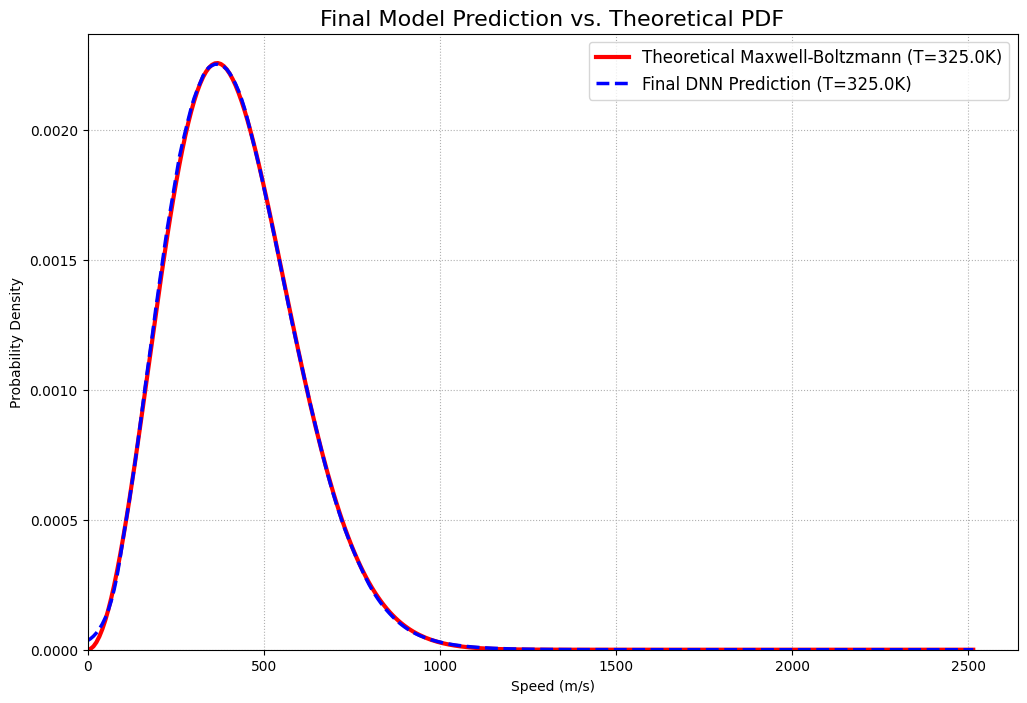


--- Final Model Prediction for a SEEN temperature (500 K) ---


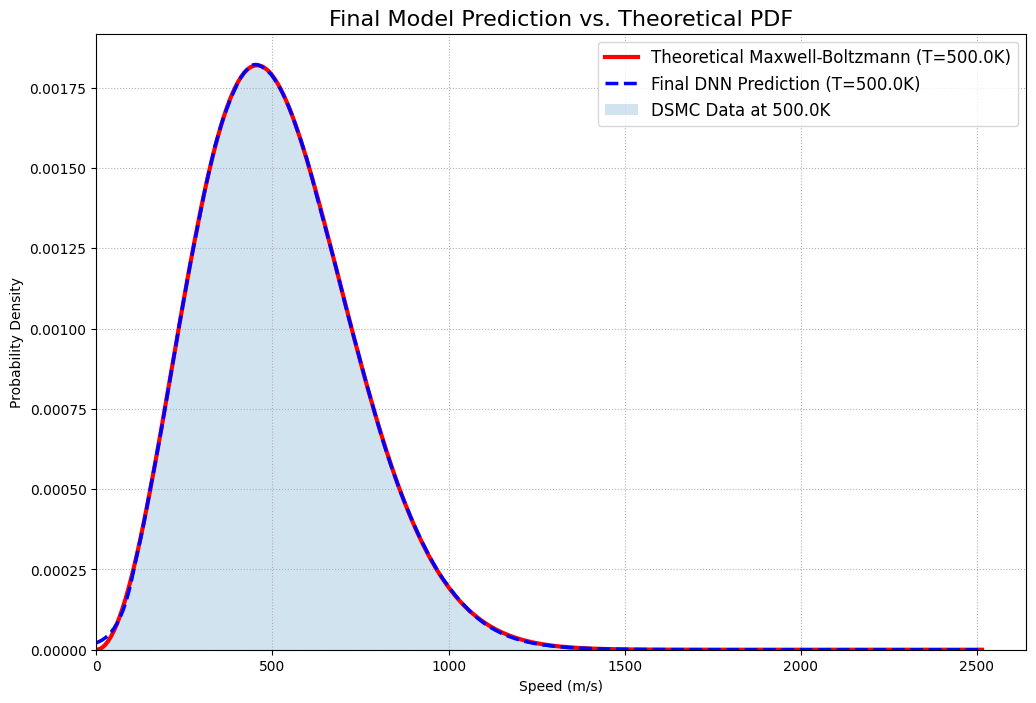

In [ ]:
# ======================================================================
# FINAL ROBUST IMPLEMENTATION: Standard Supervised Deep Neural Network
# This version is optimized for GPU execution using a tf.data pipeline.
# ======================================================================

# --- Step 1: Imports and Setup ---
import numpy as np
import matplotlib.pyplot as plt
import numba
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow Version:", tf.__version__)
print("Numba Version:", numba.__version__)

# --- Step 2: DSMC Data Generation Function ---
# (Using the original, proven DSMC code)

# Constants
MOLAR_MASS_AR = 39.948e-3; AVOGADRO_NUM = 6.022e23; MASS_AR = MOLAR_MASS_AR / AVOGADRO_NUM; KB = 1.380649e-23; D_REF_AR = 4.17e-10; T_REF_AR = 273.0; OMEGA_VHS = 0.81

@numba.jit(nopython=True)
def calculate_vhs_cross_section_numba(vr_mag):
    if vr_mag < 1e-9: return 1e-30
    exponent = OMEGA_VHS - 0.5; c_ref_sq = 2 * KB * T_REF_AR / MASS_AR; gamma_val = 1.04533
    d_sq = (D_REF_AR**2) * ((c_ref_sq / vr_mag**2)**exponent) * (1 / gamma_val)
    return np.pi * d_sq

@numba.jit(nopython=True)
def perform_collisions_in_cell_numba(particles, indices_in_cell, cell_vol, dt, fnum, sigma_vr_max):
    num_particles_in_cell = len(indices_in_cell)
    if num_particles_in_cell < 2: return
    num_candidate_pairs = (num_particles_in_cell * (num_particles_in_cell - 1) * fnum * sigma_vr_max * dt) / (2.0 * cell_vol)
    num_pairs_to_select = int(np.floor(num_candidate_pairs + np.random.rand()))
    for _ in range(num_pairs_to_select):
        idx1_local = np.random.randint(0, num_particles_in_cell)
        idx2_local = np.random.randint(0, num_particles_in_cell)
        while idx1_local == idx2_local: idx2_local = np.random.randint(0, num_particles_in_cell)
        p1_idx, p2_idx = indices_in_cell[idx1_local], indices_in_cell[idx2_local]
        vrx, vry, vrz = particles[p1_idx, 1] - particles[p2_idx, 1], particles[p1_idx, 2] - particles[p2_idx, 2], particles[p1_idx, 3] - particles[p2_idx, 3]
        vr_mag = np.sqrt(vrx**2 + vry**2 + vrz**2)
        if vr_mag < 1e-9: continue
        sigma_t = calculate_vhs_cross_section_numba(vr_mag)
        if np.random.rand() < (sigma_t * vr_mag) / sigma_vr_max:
            vcm_x, vcm_y, vcm_z = 0.5 * (particles[p1_idx, 1] + particles[p2_idx, 1]), 0.5 * (particles[p1_idx, 2] + particles[p2_idx, 2]), 0.5 * (particles[p1_idx, 3] + particles[p2_idx, 3])
            cos_chi = 2 * np.random.rand() - 1.0; sin_chi = np.sqrt(1.0 - cos_chi**2); phi_chi = 2.0 * np.pi * np.random.rand()
            vr_prime_x, vr_prime_y, vr_prime_z = vr_mag * sin_chi * np.cos(phi_chi), vr_mag * sin_chi * np.sin(phi_chi), vr_mag * cos_chi
            particles[p1_idx, 1:4] = vcm_x + 0.5 * vr_prime_x, vcm_y + 0.5 * vr_prime_y, vcm_z + 0.5 * vr_prime_z
            particles[p2_idx, 1:4] = vcm_x - 0.5 * vr_prime_x, vcm_y - 0.5 * vr_prime_y, vcm_z - 0.5 * vr_prime_z

def run_dsmc_simulation(target_temp, params):
    print(f"\n--- Running DSMC for T = {target_temp} K with '{params['name']}' settings ---")
    NUM_CELLS_X = params['num_cells']; PARTICLES_PER_CELL_INIT = params['particles_per_cell']; TOTAL_TIME = params['total_time']; SAMPLING_START_TIME = params['sampling_start']
    TOTAL_PARTICLES_SIM = NUM_CELLS_X * PARTICLES_PER_CELL_INIT; LX=1.0e-6; RHO_INIT=1.78
    N_DENSITY_REAL = RHO_INIT / MASS_AR; CELL_VOLUME_CONCEPTUAL = (LX**3) / NUM_CELLS_X
    FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT
    DT=1.0e-11; NUM_STEPS=int(TOTAL_TIME/DT); SAMPLING_START_STEP=int(SAMPLING_START_TIME/DT)
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4)); cell_width = LX / NUM_CELLS_X
    for i in range(NUM_CELLS_X):
        start_idx, end_idx = i * PARTICLES_PER_CELL_INIT, (i + 1) * PARTICLES_PER_CELL_INIT
        particles[start_idx:end_idx, 0] = i * cell_width + np.random.rand(PARTICLES_PER_CELL_INIT) * cell_width
    particles[:, 1:4] = 800.0 * (2.0 * np.random.rand(TOTAL_PARTICLES_SIM, 3) - 1.0)
    current_total_ke = 0.5 * MASS_AR * np.sum(particles[:, 1:4]**2); target_total_ke = 1.5 * TOTAL_PARTICLES_SIM * KB * target_temp
    scaling_factor = np.sqrt(target_total_ke / current_total_ke); particles[:, 1:4] *= scaling_factor
    vr_max_estimate = 10.0 * np.sqrt(KB * target_temp / MASS_AR); SIGMA_VR_MAX_GLOBAL = calculate_vhs_cross_section_numba(vr_max_estimate) * vr_max_estimate
    sampled_speeds_accumulator = []
    print(f"Starting simulation for {NUM_STEPS} steps...")
    for step in range(1, NUM_STEPS + 1):
        particles[:, 0] = (particles[:, 0] + particles[:, 1] * DT) % LX
        cell_indices = (particles[:, 0] / cell_width).astype(np.int64); sorted_particle_indices = np.argsort(cell_indices)
        cell_counts = np.bincount(cell_indices, minlength=NUM_CELLS_X); cell_start_indices = np.concatenate(([0], np.cumsum(cell_counts[:-1])))
        for i in range(NUM_CELLS_X):
            start, end = cell_start_indices[i], cell_start_indices[i] + cell_counts[i]
            perform_collisions_in_cell_numba(particles, sorted_particle_indices[start:end], CELL_VOLUME_CONCEPTUAL, DT, FNUM, SIGMA_VR_MAX_GLOBAL)
        if step >= SAMPLING_START_STEP: sampled_speeds_accumulator.extend(np.sqrt(np.sum(particles[:, 1:4]**2, axis=1)))
        if step % (NUM_STEPS // 4) == 0: print(f"    ... T={target_temp}K, Step {step}/{NUM_STEPS} completed ...")
    print(f"DSMC for T = {target_temp} K finished. Collected {len(sampled_speeds_accumulator)} samples.")
    return np.array(sampled_speeds_accumulator)

# --- Step 3: High-Quality Data Generation and Preprocessing ---
simulation_params = {
    "name": "High Quality",
    "num_cells": 20,
    "particles_per_cell": 500,
    "total_time": 8.0e-7,
    "sampling_start": 4.0e-7,
}
training_temperatures = [200.0, 275.0, 350.0, 425.0, 500.0, 575.0, 650.0]
dsmc_results = {}
for temp in training_temperatures:
    dsmc_results[temp] = run_dsmc_simulation(target_temp=temp, params=simulation_params)

NUM_BINS = 200
X_train_list, y_train_list = [], []
for temp, speeds in dsmc_results.items():
    hist, bin_edges = np.histogram(speeds, bins=NUM_BINS, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    for i in range(len(bin_centers)):
        X_train_list.append([bin_centers[i], temp])
        y_train_list.append(hist[i])
print("\nInjecting physical boundary condition (v=0, P=0)...")
for temp in training_temperatures:
    X_train_list.append([0.0, temp])
    y_train_list.append(0.0)
X_train, y_train = np.array(X_train_list), np.array(y_train_list)
x_mean, x_std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train_normalized = (X_train - x_mean) / x_std
y_max = np.max(y_train)
y_train_normalized = y_train / y_max
print(f"\nCreated a high-quality training dataset with {len(X_train)} samples.")


# --- Step 4: Define and Train the Final, Stable DNN Model (GPU OPTIMIZED) ---

# --- GPU Optimization 1: Deeper Model Architecture ---
# A slightly deeper model can better leverage the parallel processing power of a GPU.
model = keras.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'), # Added layer
    layers.Dense(1, activation='softplus')
], name="Final_DNN_GPU")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

# --- GPU Optimization 2: Use tf.data.Dataset for Efficient Data Input ---
# This creates a highly efficient data pipeline that feeds the GPU without bottlenecks.
BATCH_SIZE = 1024 # Larger batch sizes are often more efficient on GPUs
SHUFFLE_BUFFER = 10000

# Create training and validation datasets
from sklearn.model_selection import train_test_split
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_train_normalized, y_train_normalized, test_size=0.2, random_state=42
)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_np))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_np, y_val_np))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"\nCreated tf.data pipelines with batch size {BATCH_SIZE}.")

print("\nStarting final model training (GPU Optimized)...")
history = model.fit(
    train_dataset, # Train on the efficient dataset
    epochs=500,
    validation_data=val_dataset, # Validate on the efficient dataset
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    ]
)
print("Training finished.")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Final Model Training History'), plt.xlabel('Epoch'), plt.ylabel('Loss (MSE)')
plt.yscale('log'), plt.legend(), plt.grid(True), plt.show()


# --- Step 5: Evaluate the Final Model ---
def plot_final_prediction(test_temp):
    max_speed_in_data = np.max([np.max(s) for s in dsmc_results.values()])
    v_test = np.linspace(0, max_speed_in_data * 1.1, 300)
    nn_input = np.stack([v_test, np.full_like(v_test, test_temp)], axis=-1)
    nn_input_normalized = (nn_input - x_mean) / x_std
    predicted_pdf_normalized = model.predict(nn_input_normalized, verbose=0)
    predicted_pdf = predicted_pdf_normalized * y_max
    theoretical_pdf = (4*np.pi*(MASS_AR/(2*np.pi*KB*test_temp))**1.5 * v_test**2 * np.exp(-MASS_AR*v_test**2/(2*KB*test_temp)))
    plt.figure(figsize=(12, 8))
    plt.plot(v_test, theoretical_pdf, 'r-', linewidth=3, label=f'Theoretical Maxwell-Boltzmann (T={test_temp}K)')
    plt.plot(v_test, predicted_pdf, 'b--', linewidth=2.5, label=f'Final DNN Prediction (T={test_temp}K)')
    if test_temp in dsmc_results:
        plt.hist(dsmc_results[test_temp], bins=NUM_BINS, density=True, alpha=0.2, label=f'DSMC Data at {test_temp}K')
    plt.title(f'Final Model Prediction vs. Theoretical PDF', fontsize=16)
    plt.xlabel('Speed (m/s)'), plt.ylabel('Probability Density'), plt.legend(fontsize=12)
    plt.grid(True, linestyle=':'), plt.xlim(left=0), plt.ylim(bottom=0), plt.show()

print("\n--- Final Model Prediction for an UNSEEN temperature (325 K) ---")
plot_final_prediction(325.0)
print("\n--- Final Model Prediction for a SEEN temperature (500 K) ---")
plot_final_prediction(500.0)


TensorFlow Version: 2.18.0
Numba Version: 0.60.0

--- Running DSMC for T = 200.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
    ... T=200.0K, Step 20000/80000 completed ...
    ... T=200.0K, Step 40000/80000 completed ...
    ... T=200.0K, Step 60000/80000 completed ...
    ... T=200.0K, Step 80000/80000 completed ...
DSMC for T = 200.0 K finished. Collected 400010000 samples.

--- Running DSMC for T = 275.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
    ... T=275.0K, Step 20000/80000 completed ...
    ... T=275.0K, Step 40000/80000 completed ...
    ... T=275.0K, Step 60000/80000 completed ...
    ... T=275.0K, Step 80000/80000 completed ...
DSMC for T = 275.0 K finished. Collected 400010000 samples.

--- Running DSMC for T = 350.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
    ... T=350.0K, Step 20000/80000 completed ...
    ... T=350.0K, Step 40000/80000 completed ...
    ... T=350.0K, Step 

Model: "Fourier_Enhanced_DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fourier_feature_projection      │ (None, 256)            │             0 │
│ (FourierFeatureProjection)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 591,617 (2.26 MB)

 Trainable params: 591,617 (2.26 MB)

 Non-trainable params: 0 (0.00 B)


Created tf.data pipelines with batch size 1024.

Starting Fourier-Enhanced model training...
Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.3093 - val_loss: 0.0908
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0773 - val_loss: 0.1128
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0933 - val_loss: 0.1172
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0955 - val_loss: 0.1175
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0969 - val_loss: 0.1156
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0954 - val_loss: 0.1104
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0900 - val_loss: 0.0979
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0777 - val_loss: 0.0742
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0582 - val_loss: 0.0681
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0605 - val_loss: 0.0663
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.057

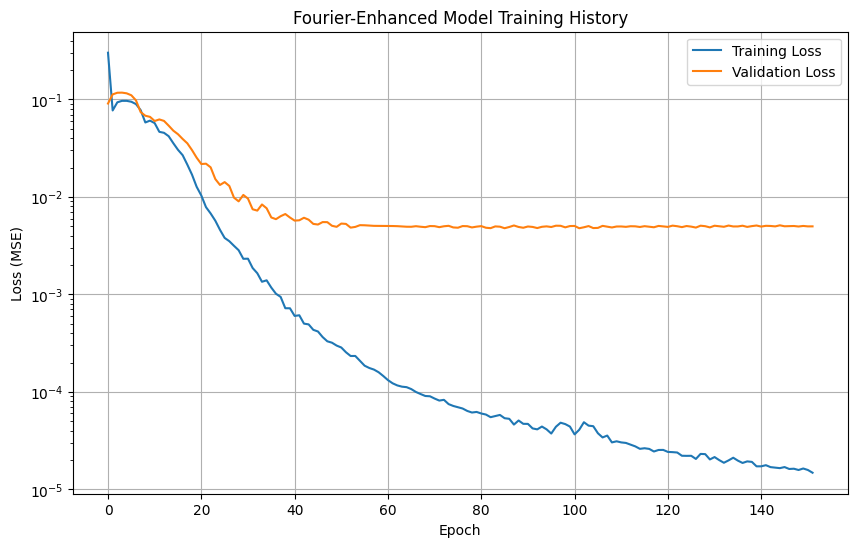


--- Model Prediction for an UNSEEN (Interpolation) temperature (325 K) ---


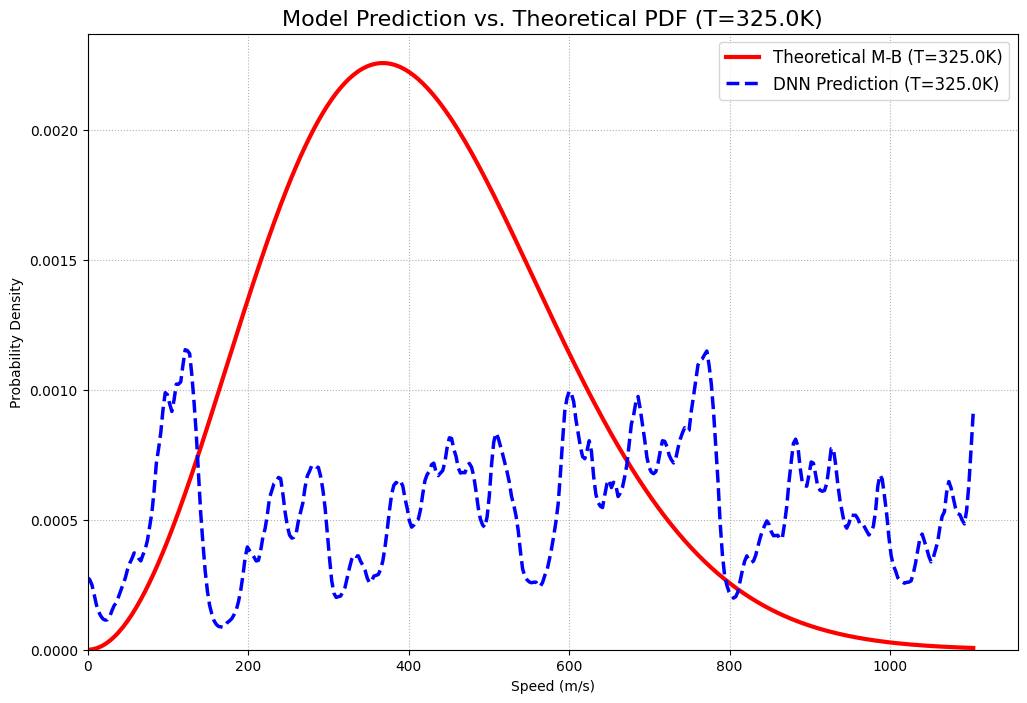


--- Model Prediction for a SEEN temperature (500 K) ---


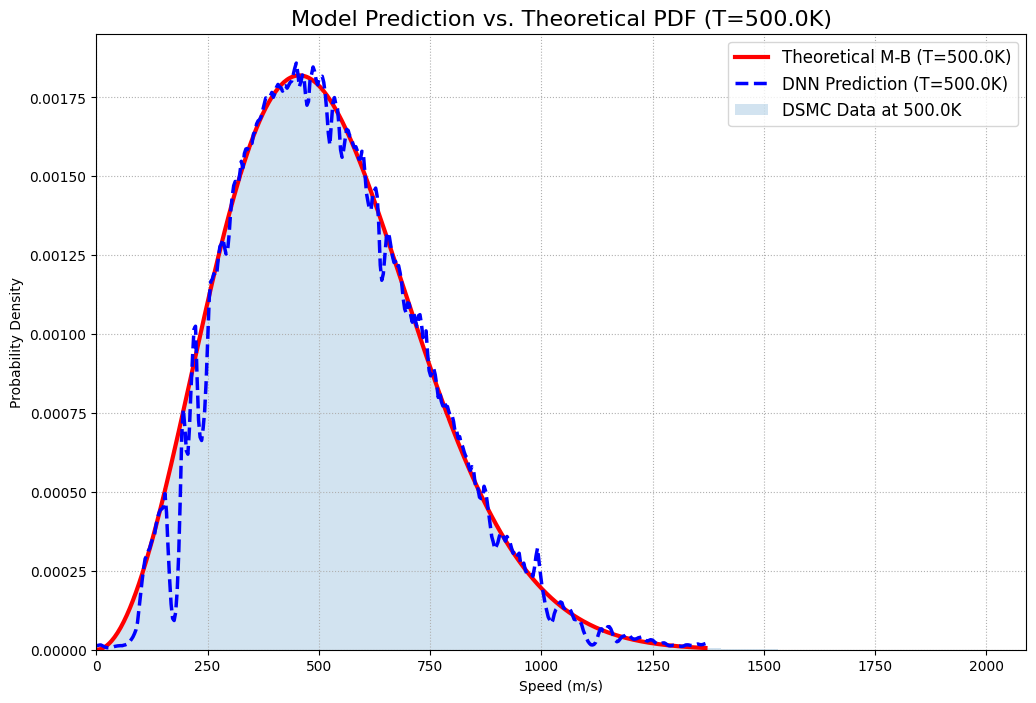


--- Model Prediction for an UNSEEN (Extrapolation) temperature (700.0 K) ---


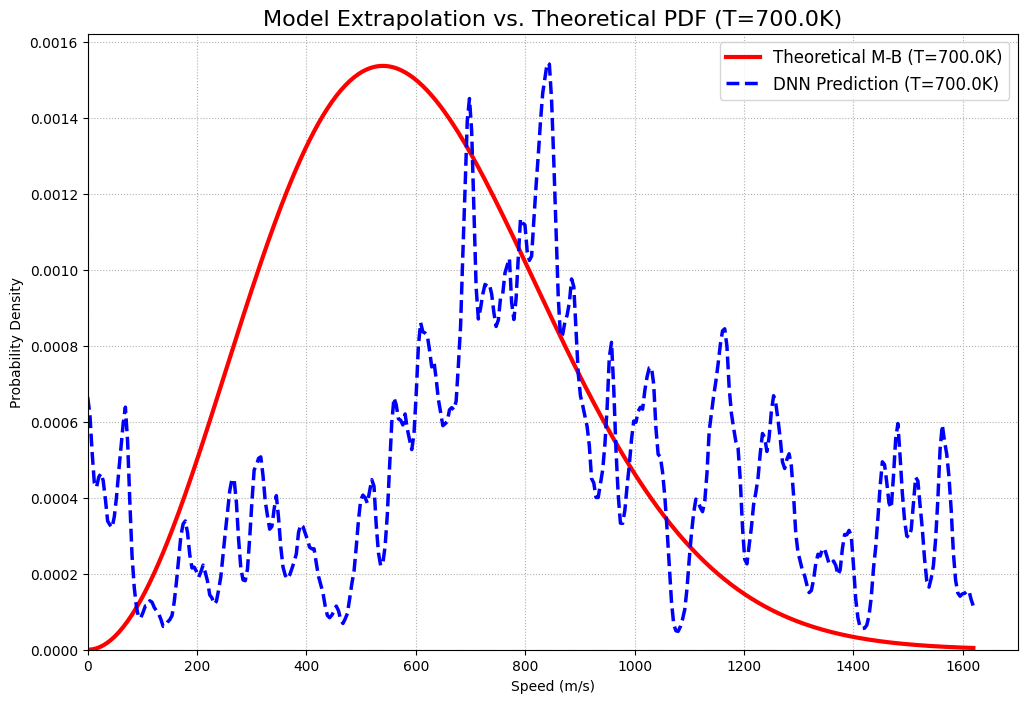


--- Model Prediction for an UNSEEN (Extrapolation) temperature (750.0 K) ---


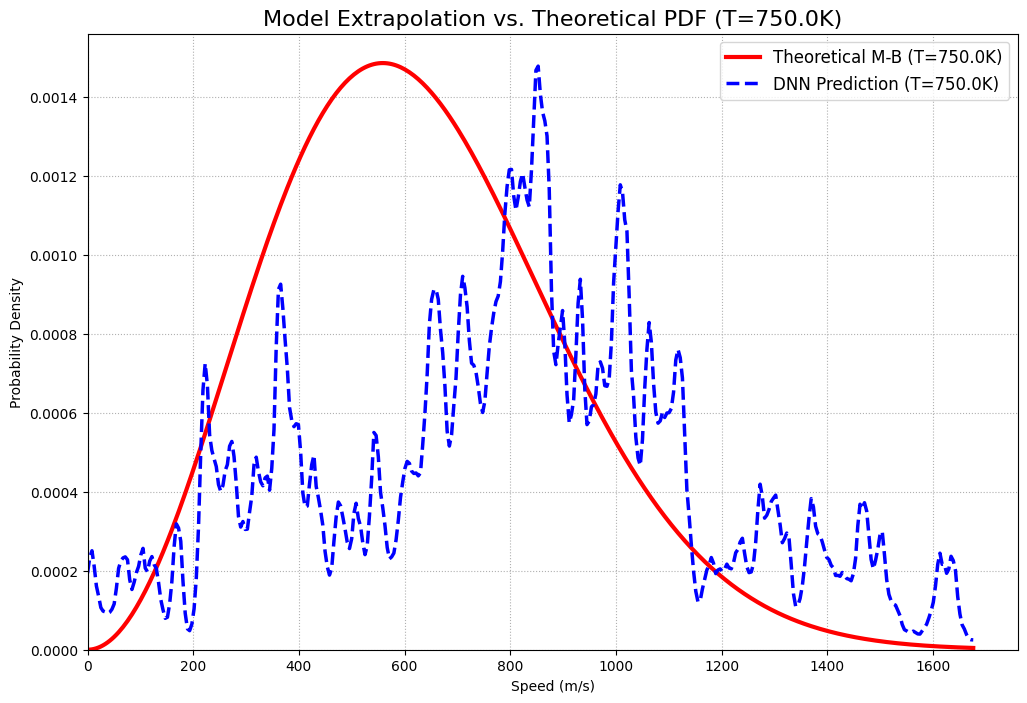


--- Model Prediction for an UNSEEN (Extrapolation) temperature (800.0 K) ---


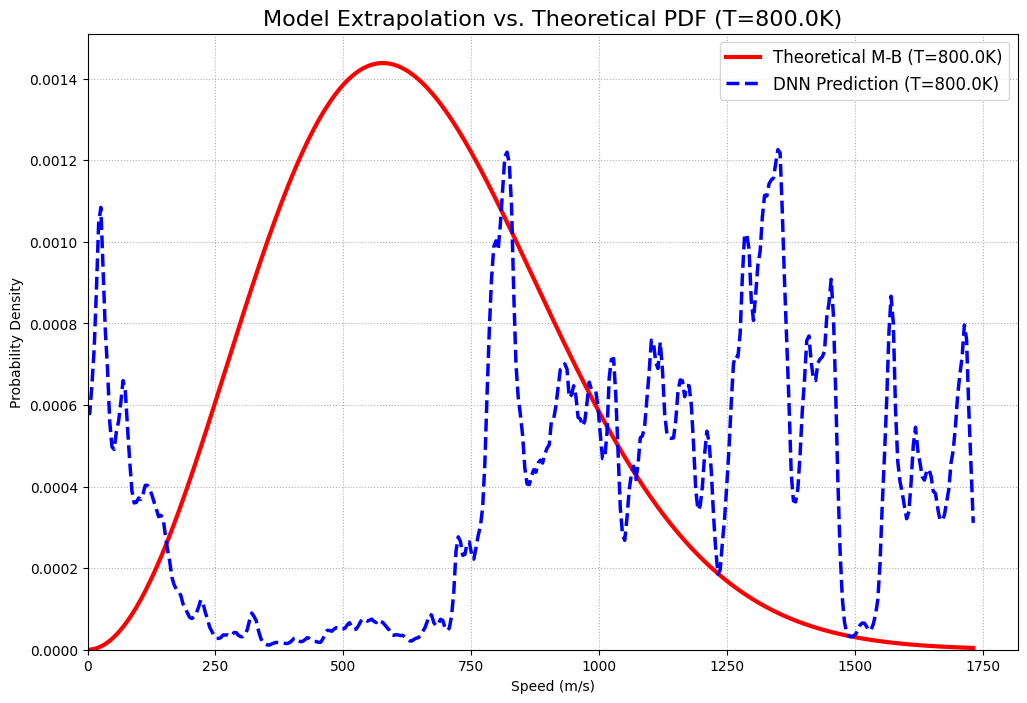


--- Model Prediction for an UNSEEN (Extrapolation) temperature (850.0 K) ---


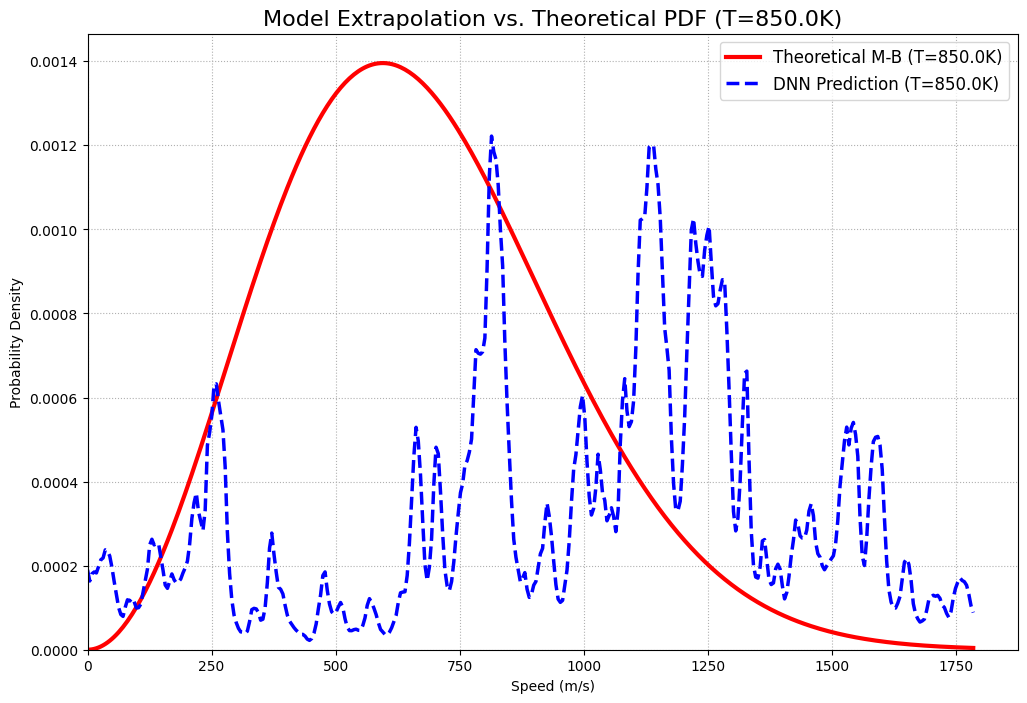

In [1]:
# ======================================================================
# FINAL ROBUST IMPLEMENTATION: DNN with Fourier Features for Extrapolation
# This version is optimized for GPU execution and enhanced extrapolation.
# ======================================================================

# --- Step 1: Imports and Setup ---
import numpy as np
import matplotlib.pyplot as plt
import numba
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow Version:", tf.__version__)
print("Numba Version:", numba.__version__)

# --- Step 2: DSMC Data Generation Function ---
# (Using the original, proven DSMC code - No changes here)

# Constants
MOLAR_MASS_AR = 39.948e-3; AVOGADRO_NUM = 6.022e23; MASS_AR = MOLAR_MASS_AR / AVOGADRO_NUM; KB = 1.380649e-23; D_REF_AR = 4.17e-10; T_REF_AR = 273.0; OMEGA_VHS = 0.81

@numba.jit(nopython=True)
def calculate_vhs_cross_section_numba(vr_mag):
    if vr_mag < 1e-9: return 1e-30
    exponent = OMEGA_VHS - 0.5; c_ref_sq = 2 * KB * T_REF_AR / MASS_AR; gamma_val = 1.04533
    d_sq = (D_REF_AR**2) * ((c_ref_sq / vr_mag**2)**exponent) * (1 / gamma_val)
    return np.pi * d_sq

@numba.jit(nopython=True)
def perform_collisions_in_cell_numba(particles, indices_in_cell, cell_vol, dt, fnum, sigma_vr_max):
    num_particles_in_cell = len(indices_in_cell)
    if num_particles_in_cell < 2: return
    num_candidate_pairs = (num_particles_in_cell * (num_particles_in_cell - 1) * fnum * sigma_vr_max * dt) / (2.0 * cell_vol)
    num_pairs_to_select = int(np.floor(num_candidate_pairs + np.random.rand()))
    for _ in range(num_pairs_to_select):
        idx1_local = np.random.randint(0, num_particles_in_cell)
        idx2_local = np.random.randint(0, num_particles_in_cell)
        while idx1_local == idx2_local: idx2_local = np.random.randint(0, num_particles_in_cell)
        p1_idx, p2_idx = indices_in_cell[idx1_local], indices_in_cell[idx2_local]
        vrx, vry, vrz = particles[p1_idx, 1] - particles[p2_idx, 1], particles[p1_idx, 2] - particles[p2_idx, 2], particles[p1_idx, 3] - particles[p2_idx, 3]
        vr_mag = np.sqrt(vrx**2 + vry**2 + vrz**2)
        if vr_mag < 1e-9: continue
        sigma_t = calculate_vhs_cross_section_numba(vr_mag)
        if np.random.rand() < (sigma_t * vr_mag) / sigma_vr_max:
            vcm_x, vcm_y, vcm_z = 0.5 * (particles[p1_idx, 1] + particles[p2_idx, 1]), 0.5 * (particles[p1_idx, 2] + particles[p2_idx, 2]), 0.5 * (particles[p1_idx, 3] + particles[p2_idx, 3])
            cos_chi = 2 * np.random.rand() - 1.0; sin_chi = np.sqrt(1.0 - cos_chi**2); phi_chi = 2.0 * np.pi * np.random.rand()
            vr_prime_x, vr_prime_y, vr_prime_z = vr_mag * sin_chi * np.cos(phi_chi), vr_mag * sin_chi * np.sin(phi_chi), vr_mag * cos_chi
            particles[p1_idx, 1:4] = vcm_x + 0.5 * vr_prime_x, vcm_y + 0.5 * vr_prime_y, vcm_z + 0.5 * vr_prime_z
            particles[p2_idx, 1:4] = vcm_x - 0.5 * vr_prime_x, vcm_y - 0.5 * vr_prime_y, vcm_z - 0.5 * vr_prime_z

def run_dsmc_simulation(target_temp, params):
    print(f"\n--- Running DSMC for T = {target_temp} K with '{params['name']}' settings ---")
    NUM_CELLS_X = params['num_cells']; PARTICLES_PER_CELL_INIT = params['particles_per_cell']; TOTAL_TIME = params['total_time']; SAMPLING_START_TIME = params['sampling_start']
    TOTAL_PARTICLES_SIM = NUM_CELLS_X * PARTICLES_PER_CELL_INIT; LX=1.0e-6; RHO_INIT=1.78
    N_DENSITY_REAL = RHO_INIT / MASS_AR; CELL_VOLUME_CONCEPTUAL = (LX**3) / NUM_CELLS_X
    FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT
    DT=1.0e-11; NUM_STEPS=int(TOTAL_TIME/DT); SAMPLING_START_STEP=int(SAMPLING_START_TIME/DT)
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4)); cell_width = LX / NUM_CELLS_X
    for i in range(NUM_CELLS_X):
        start_idx, end_idx = i * PARTICLES_PER_CELL_INIT, (i + 1) * PARTICLES_PER_CELL_INIT
        particles[start_idx:end_idx, 0] = i * cell_width + np.random.rand(PARTICLES_PER_CELL_INIT) * cell_width
    particles[:, 1:4] = 800.0 * (2.0 * np.random.rand(TOTAL_PARTICLES_SIM, 3) - 1.0)
    current_total_ke = 0.5 * MASS_AR * np.sum(particles[:, 1:4]**2); target_total_ke = 1.5 * TOTAL_PARTICLES_SIM * KB * target_temp
    scaling_factor = np.sqrt(target_total_ke / current_total_ke); particles[:, 1:4] *= scaling_factor
    vr_max_estimate = 10.0 * np.sqrt(KB * target_temp / MASS_AR); SIGMA_VR_MAX_GLOBAL = calculate_vhs_cross_section_numba(vr_max_estimate) * vr_max_estimate
    sampled_speeds_accumulator = []
    print(f"Starting simulation for {NUM_STEPS} steps...")
    for step in range(1, NUM_STEPS + 1):
        particles[:, 0] = (particles[:, 0] + particles[:, 1] * DT) % LX
        cell_indices = (particles[:, 0] / cell_width).astype(np.int64); sorted_particle_indices = np.argsort(cell_indices)
        cell_counts = np.bincount(cell_indices, minlength=NUM_CELLS_X); cell_start_indices = np.concatenate(([0], np.cumsum(cell_counts[:-1])))
        for i in range(NUM_CELLS_X):
            start, end = cell_start_indices[i], cell_start_indices[i] + cell_counts[i]
            perform_collisions_in_cell_numba(particles, sorted_particle_indices[start:end], CELL_VOLUME_CONCEPTUAL, DT, FNUM, SIGMA_VR_MAX_GLOBAL)
        if step >= SAMPLING_START_STEP: sampled_speeds_accumulator.extend(np.sqrt(np.sum(particles[:, 1:4]**2, axis=1)))
        if step % (NUM_STEPS // 4) == 0: print(f"    ... T={target_temp}K, Step {step}/{NUM_STEPS} completed ...")
    print(f"DSMC for T = {target_temp} K finished. Collected {len(sampled_speeds_accumulator)} samples.")
    return np.array(sampled_speeds_accumulator)

# --- Step 3: High-Quality Data Generation and Preprocessing ---
# (Using the same training data as requested)
simulation_params = {
    "name": "High Quality",
    "num_cells": 20,
    "particles_per_cell": 500,
    "total_time": 8.0e-7,
    "sampling_start": 4.0e-7,
}
training_temperatures = [200.0, 275.0, 350.0, 425.0, 500.0, 575.0, 650.0]
dsmc_results = {}
for temp in training_temperatures:
    dsmc_results[temp] = run_dsmc_simulation(target_temp=temp, params=simulation_params)

NUM_BINS = 200
X_train_list, y_train_list = [], []
for temp, speeds in dsmc_results.items():
    hist, bin_edges = np.histogram(speeds, bins=NUM_BINS, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    for i in range(len(bin_centers)):
        X_train_list.append([bin_centers[i], temp])
        y_train_list.append(hist[i])
print("\nInjecting physical boundary condition (v=0, P=0)...")
for temp in training_temperatures:
    X_train_list.append([0.0, temp])
    y_train_list.append(0.0)
X_train, y_train = np.array(X_train_list), np.array(y_train_list)

# IMPORTANT: Normalization now happens *inside* the Fourier layer,
# so we only need the stats for un-normalization later.
x_mean, x_std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
y_max = np.max(y_train)
y_train_normalized = y_train / y_max
print(f"\nCreated a high-quality training dataset with {len(X_train)} samples.")
print(f"Training will be on temperatures from {min(training_temperatures)}K to {max(training_temperatures)}K.")


# --- Step 4: Define and Train the Fourier-Enhanced DNN Model ---

# --- NEW: Fourier Feature Projection Layer ---
class FourierFeatureProjection(tf.keras.layers.Layer):
    def __init__(self, projection_dim, scale=10.0):
        super(FourierFeatureProjection, self).__init__()
        self.projection_dim = projection_dim
        # The projection matrix `B` is created once and is not trainable.
        self.scale = scale

    def build(self, input_shape):
        # Using shape from the input tensor to create the projection matrix
        input_dim = input_shape[-1]
        # projection_dim must be even
        half_dim = self.projection_dim // 2
        self.gaussian_matrix = tf.random.normal(shape=(input_dim, half_dim)) * self.scale
        super(FourierFeatureProjection, self).build(input_shape)

    def call(self, x):
        # Normalize inputs before projection
        x_mean_tf = tf.constant(x_mean, dtype=tf.float32)
        x_std_tf = tf.constant(x_std, dtype=tf.float32)
        x_normalized = (x - x_mean_tf) / x_std_tf

        # Project the normalized inputs
        x_proj = (2. * np.pi * x_normalized) @ self.gaussian_matrix
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- Model with Fourier Features ---
# We feed the raw (unnormalized) data to the model. Normalization and projection
# happen inside the Fourier Feature layer.
model = keras.Sequential([
    layers.Input(shape=(2,)),
    FourierFeatureProjection(projection_dim=256, scale=5.0), # Add Fourier layer
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='softplus')
], name="Fourier_Enhanced_DNN")

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

# --- Use tf.data.Dataset for Efficient Data Input ---
BATCH_SIZE = 1024
SHUFFLE_BUFFER = 10000

from sklearn.model_selection import train_test_split
# Note: We now use the original X_train, not the normalized version
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_train, y_train_normalized, test_size=0.2, random_state=42
)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_np))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_np, y_val_np))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"\nCreated tf.data pipelines with batch size {BATCH_SIZE}.")

print("\nStarting Fourier-Enhanced model training...")
history = model.fit(
    train_dataset,
    epochs=500,
    validation_data=val_dataset,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    ]
)
print("Training finished.")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Fourier-Enhanced Model Training History'), plt.xlabel('Epoch'), plt.ylabel('Loss (MSE)')
plt.yscale('log'), plt.legend(), plt.grid(True), plt.show()


# --- Step 5: Evaluate the Final Model (Interpolation and EXTRAPOLATION) ---
def plot_prediction(test_temp, is_extrapolation=False):
    # Determine a reasonable speed range for plotting based on temperature
    max_speed_plot = 3 * np.sqrt(2 * KB * test_temp / MASS_AR) # Estimate based on thermal velocity
    v_test = np.linspace(0, max_speed_plot, 400)
    nn_input = np.stack([v_test, np.full_like(v_test, test_temp)], axis=-1)

    # The model expects raw inputs, as normalization is internal
    predicted_pdf_normalized = model.predict(nn_input, verbose=0)
    predicted_pdf = predicted_pdf_normalized * y_max

    # Calculate theoretical Maxwell-Boltzmann for comparison
    theoretical_pdf = (4*np.pi*(MASS_AR/(2*np.pi*KB*test_temp))**1.5 * v_test**2 * np.exp(-MASS_AR*v_test**2/(2*KB*test_temp)))

    plt.figure(figsize=(12, 8))
    title_prefix = "Extrapolation" if is_extrapolation else "Prediction"
    plt.title(f'Model {title_prefix} vs. Theoretical PDF (T={test_temp}K)', fontsize=16)

    plt.plot(v_test, theoretical_pdf, 'r-', linewidth=3, label=f'Theoretical M-B (T={test_temp}K)')
    plt.plot(v_test, predicted_pdf, 'b--', linewidth=2.5, label=f'DNN Prediction (T={test_temp}K)')

    # If it's a training temperature, also plot the DSMC data
    if test_temp in dsmc_results:
        plt.hist(dsmc_results[test_temp], bins=NUM_BINS, density=True, alpha=0.2, label=f'DSMC Data at {test_temp}K')

    plt.xlabel('Speed (m/s)'), plt.ylabel('Probability Density'), plt.legend(fontsize=12)
    plt.grid(True, linestyle=':'), plt.xlim(left=0), plt.ylim(bottom=0), plt.show()


# --- Interpolation Tests (within training range) ---
print("\n--- Model Prediction for an UNSEEN (Interpolation) temperature (325 K) ---")
plot_prediction(325.0)
print("\n--- Model Prediction for a SEEN temperature (500 K) ---")
plot_prediction(500.0)


# --- NEW: Extrapolation Tests (outside training range) ---
max_train_temp = max(training_temperatures)
extrapolation_temps = [max_train_temp + 50, max_train_temp + 100, max_train_temp + 150, max_train_temp + 200]

for temp in extrapolation_temps:
    print(f"\n--- Model Prediction for an UNSEEN (Extrapolation) temperature ({temp} K) ---")
    plot_prediction(temp, is_extrapolation=True)

Epoch [500/3000], Loss: 0.12100077
Epoch [1000/3000], Loss: 0.00804565
Epoch [1500/3000], Loss: 0.00927767
Epoch [2000/3000], Loss: 0.00516436
Epoch [2500/3000], Loss: 0.01511741
Epoch [3000/3000], Loss: 0.00362208


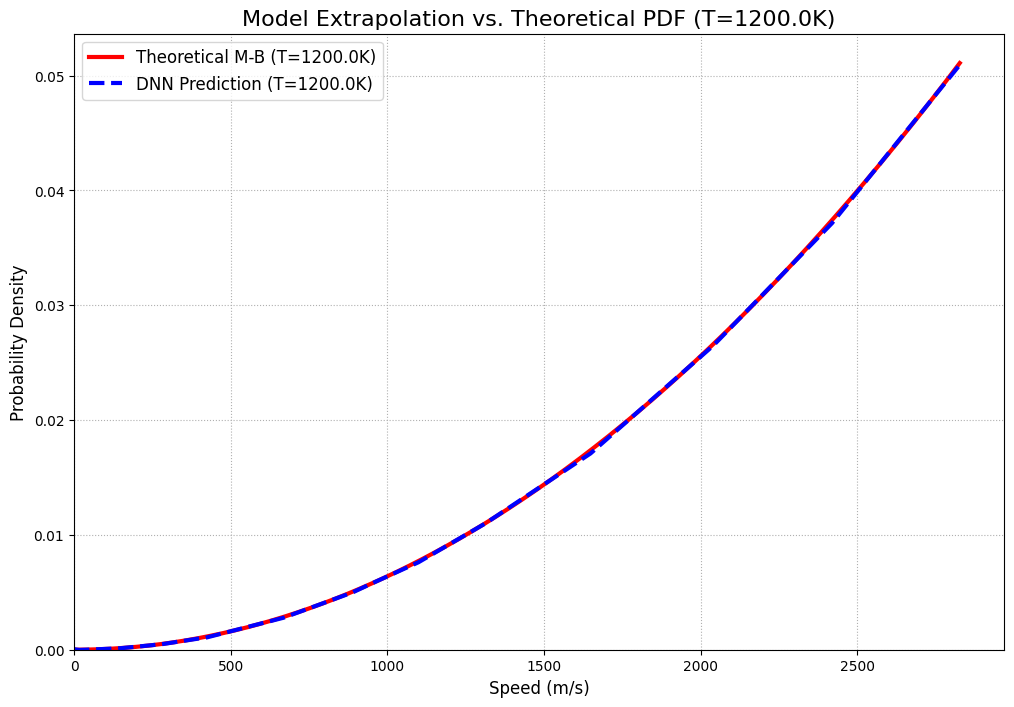

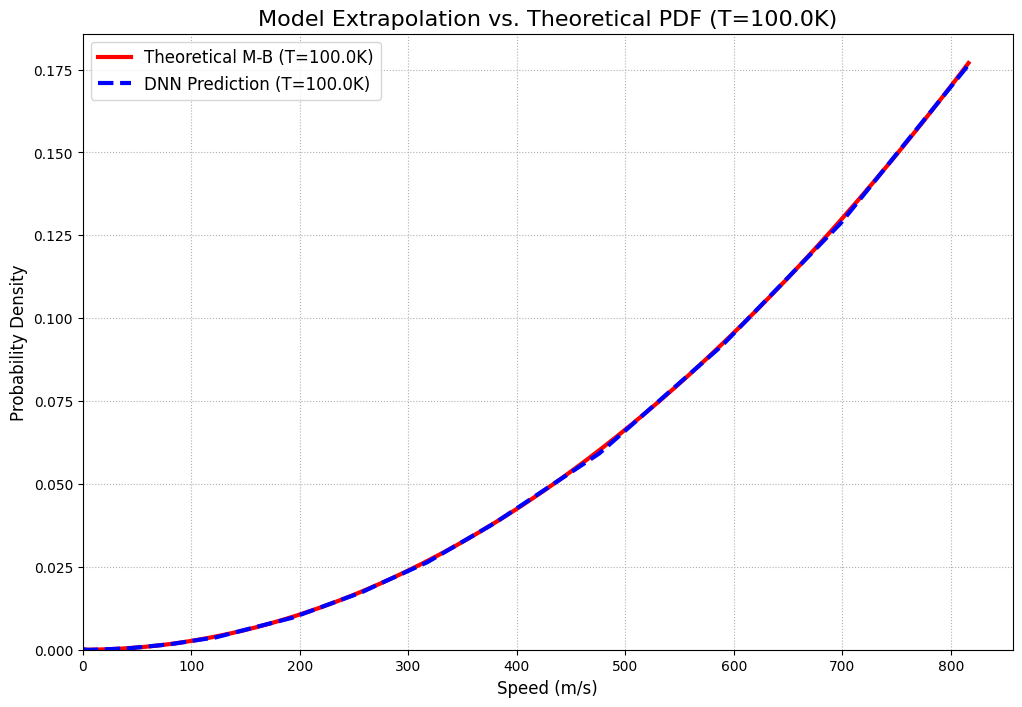

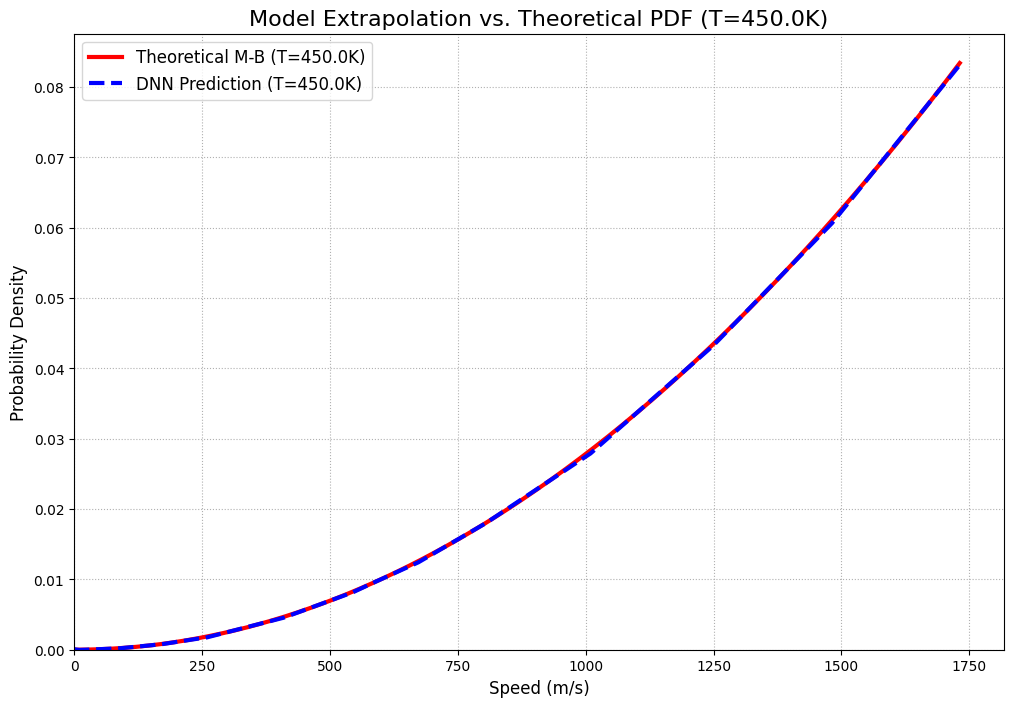

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ثابت‌های فیزیکی
K_B = 1.380649e-23  # ثابت بولتزمن J/K
M_ARGON = 6.6335209e-26 # جرم اتم آرگون به کیلوگرم

# --- 1. توابع کمکی برای بی‌بُعدسازی بر اساس فیزیک مسئله ---

def get_most_probable_speed(T, m=M_ARGON):
    """محاسبه محتمل‌ترین سرعت (سرعت مشخصه)"""
    return np.sqrt(2 * K_B * T / m)

def to_nondimensional(speed, pdf, T, m=M_ARGON):
    """تبدیل مقادیر فیزیکی به مقادیر بی‌بُعد"""
    vp = get_most_probable_speed(T, m)
    v_tilde = speed / vp
    pdf_tilde = pdf * vp
    return v_tilde, pdf_tilde

def from_nondimensional(v_tilde, pdf_tilde, T, m=M_ARGON):
    """تبدیل مقادیر بی‌بُعد به مقادیر فیزیکی"""
    vp = get_most_probable_speed(T, m)
    speed = v_tilde * vp
    pdf = pdf_tilde / vp
    return speed, pdf

def maxwell_boltzmann_pdf(speed, T, m=M_ARGON):
    """تابع چگالی احتمال ماکسول-بولتزمن (برای تولید داده و مقایسه)"""
    term1 = (m / (2 * np.pi * K_B * T))**1.5
    term2 = 4 * np.pi * speed**2
    term3 = np.exp(-m * speed**2 / (2 * K_B * T))
    return term1 * term2

# --- 2. تولید داده‌های آموزشی بی‌بُعد ---
# محدوده دما برای آموزش را عمدا محدود می‌کنیم تا قدرت برون‌یابی را بسنجیم
train_temps = np.linspace(200.0, 600.0, 5) # آموزش فقط تا 600 کلوین
speeds_domain = np.linspace(1, 2500, 500)

input_data_nondim = []
output_data_nondim = []

for temp in train_temps:
    # تولید داده‌های فیزیکی
    pdfs = maxwell_boltzmann_pdf(speeds_domain, temp)
    # تبدیل به داده‌های بی‌بُعد
    v_tilde, pdf_tilde = to_nondimensional(speeds_domain, pdfs, temp)

    # ورودی شبکه: سرعت بی‌بُعد
    input_data_nondim.extend(v_tilde)
    # خروجی شبکه: چگالی احتمال بی‌بُعد
    output_data_nondim.extend(pdf_tilde)

# تبدیل به تنسورهای PyTorch
# ورودی شبکه 1 بعدی است
X = torch.tensor(input_data_nondim, dtype=torch.float32).view(-1, 1)
y = torch.tensor(output_data_nondim, dtype=torch.float32).view(-1, 1)

# نیازی به نرمال‌سازی پیچیده نیست چون مقادیر بی‌بُعد خودشان خوش‌مقیلس هستند

# --- 3. تعریف معماری شبکه عصبی ---
# شبکه یک تابع جهان‌شمول را یاد می‌گیرد
class UniversalPDFPredictor(nn.Module):
    def __init__(self):
        super(UniversalPDFPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 64),   # ورودی 1 بعدی (سرعت بی‌بُعد)
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)    # خروجی 1 بعدی (چگالی احتمال بی‌بُعد)
        )

    def forward(self, x):
        return self.network(x)

# --- 4. آموزش مدل ---
model = UniversalPDFPredictor()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

epochs = 3000
batch_size = 512

for epoch in range(epochs):
    permutation = torch.randperm(X.size(0))
    for i in range(0, X.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X[indices], y[indices]

        y_pred = model(batch_x)
        loss = loss_fn(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.8f}')

# --- 5. تست مدل برای برون‌یابی و رسم نتایج ---
def plot_extrapolation(temp_to_test):
    """
    این تابع قدرت واقعی مدل را در برون‌یابی نشان می‌دهد.
    """
    model.eval()

    # 1. یک دامنه از سرعت‌های بی‌بُعد ایجاد می‌کنیم
    v_tilde_domain = torch.linspace(0, 4, 500, dtype=torch.float32).view(-1, 1)

    with torch.no_grad():
        # 2. شبکه، PDF بی‌بُعد را برای این دامنه‌ی جهان‌شمول پیش‌بینی می‌کند
        pdf_tilde_predicted = model(v_tilde_domain)

    # 3. پیش‌بینی بی‌بُعد را به مقادیر فیزیکی برای دمای مورد نظر تبدیل می‌کنیم
    predicted_speeds, predicted_pdf = from_nondimensional(
        v_tilde_domain.numpy(), pdf_tilde_predicted.numpy(), temp_to_test
    )

    # محاسبه منحنی تئوری برای مقایسه
    theoretical_pdf = maxwell_boltzmann_pdf(predicted_speeds, temp_to_test)

    # رسم نمودار
    plt.figure(figsize=(12, 8))
    plt.plot(predicted_speeds, theoretical_pdf, 'r-', linewidth=3, label=f'Theoretical M-B (T={temp_to_test}K)')
    plt.plot(predicted_speeds, predicted_pdf, 'b--', linewidth=3, label=f'DNN Prediction (T={temp_to_test}K)')
    plt.title(f'Model Extrapolation vs. Theoretical PDF (T={temp_to_test}K)', fontsize=16)
    plt.xlabel('Speed (m/s)', fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle=':')
    plt.xlim(0)
    plt.ylim(bottom=0)
    plt.show()

# **تست اصلی: برون‌یابی برای دمایی بسیار بالاتر از محدوده آموزش**
# مدل فقط تا دمای 600K را دیده است.
plot_extrapolation(1200.0)

# تست برای دمای پایین (برون‌یابی)
plot_extrapolation(100.0)

# تست درونیابی (برای اطمینان)
plot_extrapolation(450.0)

TensorFlow Version: 2.18.0
Numba Version: 0.60.0

--- Running DSMC for T = 200.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
     ... T=200.0K, Step 20000/80000 completed ...
     ... T=200.0K, Step 40000/80000 completed ...
     ... T=200.0K, Step 60000/80000 completed ...
     ... T=200.0K, Step 80000/80000 completed ...
DSMC for T = 200.0 K finished. Collected 400010000 samples.

--- Running DSMC for T = 275.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
     ... T=275.0K, Step 20000/80000 completed ...
     ... T=275.0K, Step 40000/80000 completed ...
     ... T=275.0K, Step 60000/80000 completed ...
     ... T=275.0K, Step 80000/80000 completed ...
DSMC for T = 275.0 K finished. Collected 400010000 samples.

--- Running DSMC for T = 350.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
     ... T=350.0K, Step 20000/80000 completed ...
     ... T=350.0K, Step 40000/80000 completed ...
     ... T=35

Model: "Fourier_DNN_Extrapolation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fourier_feature_expansion       │ (None, 256)            │             0 │
│ (FourierFeatureExpansion)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 591,617 (2.26 MB)

 Trainable params: 591,617 (2.26 MB)

 Non-trainable params: 0 (0.00 B)


Created tf.data pipelines with batch size 1024.

Starting Fourier-DNN model training...
Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.5608 - val_loss: 0.0788
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0660 - val_loss: 0.1044
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0841 - val_loss: 0.1104
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0892 - val_loss: 0.1092
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0894 - val_loss: 0.1033
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0844 - val_loss: 0.0903
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0732 - val_loss: 0.0673
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0536 - val_loss: 0.0429
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0356 - val_loss: 0.0442
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0405 - val_loss: 0.0326
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0279 - v

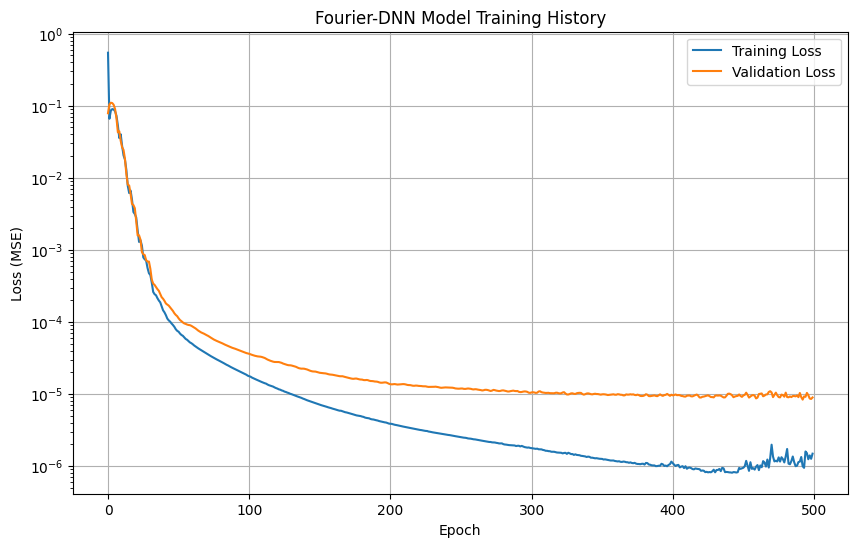


--- Model Prediction for UNSEEN (Interpolation) temperature (325 K) ---


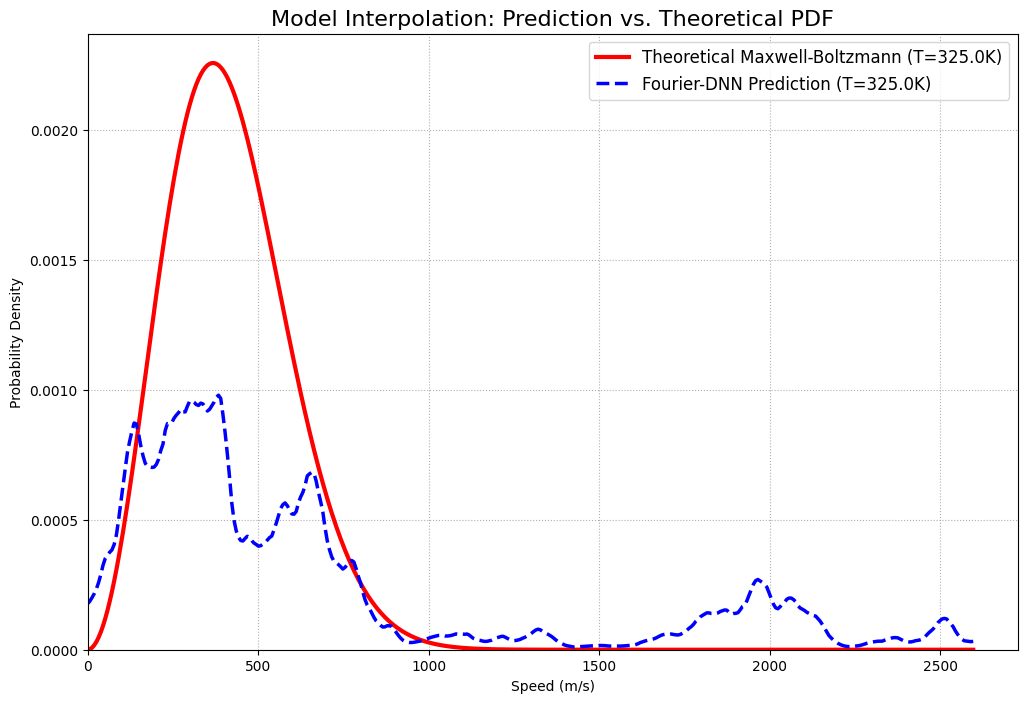


--- Model Prediction for SEEN temperature (500 K) ---


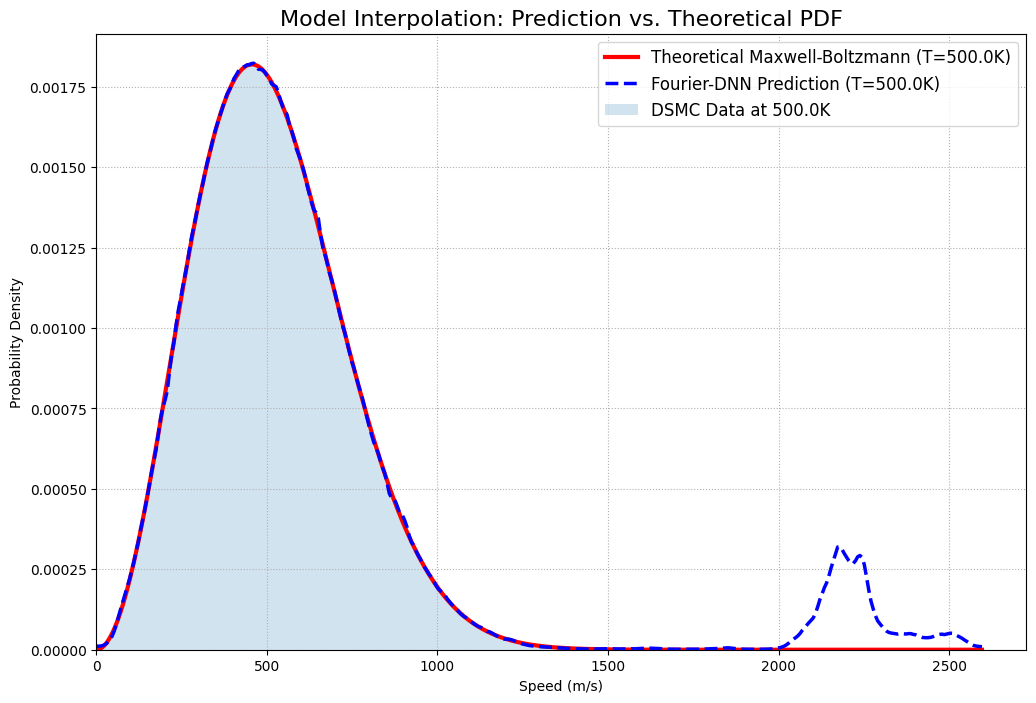


--- Model Prediction for UNSEEN (EXTRAPOLATION) temperature (900 K) ---


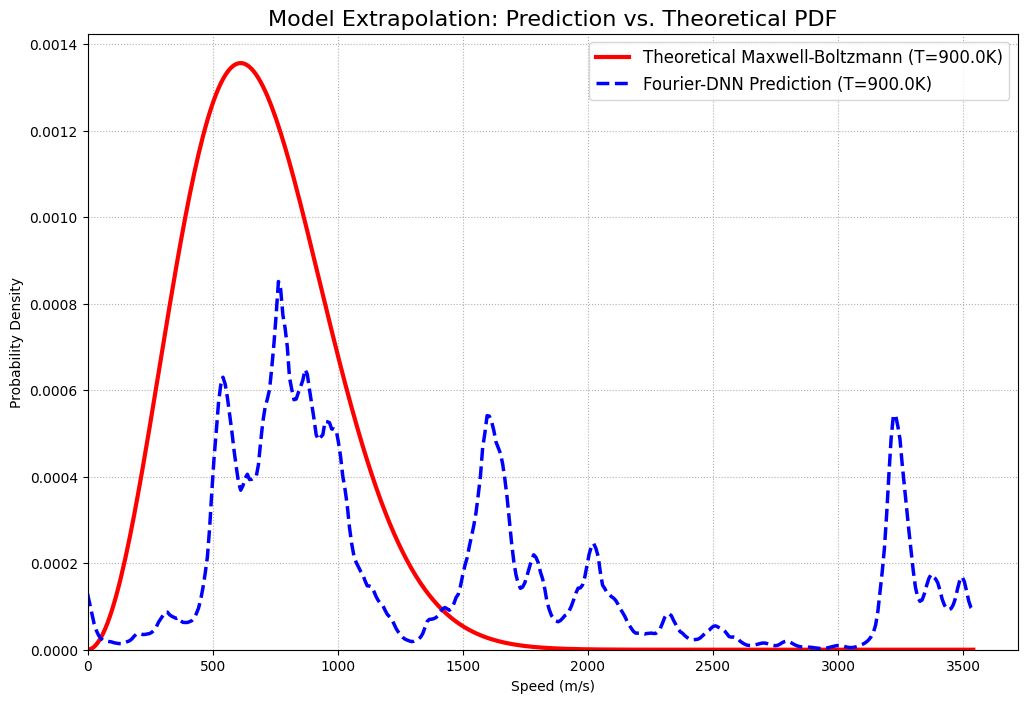

In [3]:
# ======================================================================
# FINAL ROBUST IMPLEMENTATION: Supervised DNN with Fourier Features
# This version is optimized for extrapolation and GPU execution.
# ======================================================================

# --- Step 1: Imports and Setup ---
import numpy as np
import matplotlib.pyplot as plt
import numba
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow Version:", tf.__version__)
print("Numba Version:", numba.__version__)

# --- Step 2: DSMC Data Generation Function ---
# (Using the original, proven DSMC code - NO CHANGES HERE)

# Constants
MOLAR_MASS_AR = 39.948e-3; AVOGADRO_NUM = 6.022e23; MASS_AR = MOLAR_MASS_AR / AVOGADRO_NUM; KB = 1.380649e-23; D_REF_AR = 4.17e-10; T_REF_AR = 273.0; OMEGA_VHS = 0.81

@numba.jit(nopython=True)
def calculate_vhs_cross_section_numba(vr_mag):
    if vr_mag < 1e-9: return 1e-30
    exponent = OMEGA_VHS - 0.5; c_ref_sq = 2 * KB * T_REF_AR / MASS_AR; gamma_val = 1.04533
    d_sq = (D_REF_AR**2) * ((c_ref_sq / vr_mag**2)**exponent) * (1 / gamma_val)
    return np.pi * d_sq

@numba.jit(nopython=True)
def perform_collisions_in_cell_numba(particles, indices_in_cell, cell_vol, dt, fnum, sigma_vr_max):
    num_particles_in_cell = len(indices_in_cell)
    if num_particles_in_cell < 2: return
    num_candidate_pairs = (num_particles_in_cell * (num_particles_in_cell - 1) * fnum * sigma_vr_max * dt) / (2.0 * cell_vol)
    num_pairs_to_select = int(np.floor(num_candidate_pairs + np.random.rand()))
    for _ in range(num_pairs_to_select):
        idx1_local = np.random.randint(0, num_particles_in_cell)
        idx2_local = np.random.randint(0, num_particles_in_cell)
        while idx1_local == idx2_local: idx2_local = np.random.randint(0, num_particles_in_cell)
        p1_idx, p2_idx = indices_in_cell[idx1_local], indices_in_cell[idx2_local]
        vrx, vry, vrz = particles[p1_idx, 1] - particles[p2_idx, 1], particles[p1_idx, 2] - particles[p2_idx, 2], particles[p1_idx, 3] - particles[p2_idx, 3]
        vr_mag = np.sqrt(vrx**2 + vry**2 + vrz**2)
        if vr_mag < 1e-9: continue
        sigma_t = calculate_vhs_cross_section_numba(vr_mag)
        if np.random.rand() < (sigma_t * vr_mag) / sigma_vr_max:
            vcm_x, vcm_y, vcm_z = 0.5 * (particles[p1_idx, 1] + particles[p2_idx, 1]), 0.5 * (particles[p1_idx, 2] + particles[p2_idx, 2]), 0.5 * (particles[p1_idx, 3] + particles[p2_idx, 3])
            cos_chi = 2 * np.random.rand() - 1.0; sin_chi = np.sqrt(1.0 - cos_chi**2); phi_chi = 2.0 * np.pi * np.random.rand()
            vr_prime_x, vr_prime_y, vr_prime_z = vr_mag * sin_chi * np.cos(phi_chi), vr_mag * sin_chi * np.sin(phi_chi), vr_mag * cos_chi
            particles[p1_idx, 1:4] = vcm_x + 0.5 * vr_prime_x, vcm_y + 0.5 * vr_prime_y, vcm_z + 0.5 * vr_prime_z
            particles[p2_idx, 1:4] = vcm_x - 0.5 * vr_prime_x, vcm_y - 0.5 * vr_prime_y, vcm_z - 0.5 * vr_prime_z

def run_dsmc_simulation(target_temp, params):
    print(f"\n--- Running DSMC for T = {target_temp} K with '{params['name']}' settings ---")
    NUM_CELLS_X = params['num_cells']; PARTICLES_PER_CELL_INIT = params['particles_per_cell']; TOTAL_TIME = params['total_time']; SAMPLING_START_TIME = params['sampling_start']
    TOTAL_PARTICLES_SIM = NUM_CELLS_X * PARTICLES_PER_CELL_INIT; LX=1.0e-6; RHO_INIT=1.78
    N_DENSITY_REAL = RHO_INIT / MASS_AR; CELL_VOLUME_CONCEPTUAL = (LX**3) / NUM_CELLS_X
    FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT
    DT=1.0e-11; NUM_STEPS=int(TOTAL_TIME/DT); SAMPLING_START_STEP=int(SAMPLING_START_TIME/DT)
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4)); cell_width = LX / NUM_CELLS_X
    for i in range(NUM_CELLS_X):
        start_idx, end_idx = i * PARTICLES_PER_CELL_INIT, (i + 1) * PARTICLES_PER_CELL_INIT
        particles[start_idx:end_idx, 0] = i * cell_width + np.random.rand(PARTICLES_PER_CELL_INIT) * cell_width
    particles[:, 1:4] = 800.0 * (2.0 * np.random.rand(TOTAL_PARTICLES_SIM, 3) - 1.0)
    current_total_ke = 0.5 * MASS_AR * np.sum(particles[:, 1:4]**2); target_total_ke = 1.5 * TOTAL_PARTICLES_SIM * KB * target_temp
    scaling_factor = np.sqrt(target_total_ke / current_total_ke); particles[:, 1:4] *= scaling_factor
    vr_max_estimate = 10.0 * np.sqrt(KB * target_temp / MASS_AR); SIGMA_VR_MAX_GLOBAL = calculate_vhs_cross_section_numba(vr_max_estimate) * vr_max_estimate
    sampled_speeds_accumulator = []
    print(f"Starting simulation for {NUM_STEPS} steps...")
    for step in range(1, NUM_STEPS + 1):
        particles[:, 0] = (particles[:, 0] + particles[:, 1] * DT) % LX
        cell_indices = (particles[:, 0] / cell_width).astype(np.int64); sorted_particle_indices = np.argsort(cell_indices)
        cell_counts = np.bincount(cell_indices, minlength=NUM_CELLS_X); cell_start_indices = np.concatenate(([0], np.cumsum(cell_counts[:-1])))
        for i in range(NUM_CELLS_X):
            start, end = cell_start_indices[i], cell_start_indices[i] + cell_counts[i]
            perform_collisions_in_cell_numba(particles, sorted_particle_indices[start:end], CELL_VOLUME_CONCEPTUAL, DT, FNUM, SIGMA_VR_MAX_GLOBAL)
        if step >= SAMPLING_START_STEP: sampled_speeds_accumulator.extend(np.sqrt(np.sum(particles[:, 1:4]**2, axis=1)))
        if step % (NUM_STEPS // 4) == 0: print(f"     ... T={target_temp}K, Step {step}/{NUM_STEPS} completed ...")
    print(f"DSMC for T = {target_temp} K finished. Collected {len(sampled_speeds_accumulator)} samples.")
    return np.array(sampled_speeds_accumulator)

# --- Step 3: High-Quality Data Generation and Preprocessing ---
# (NO CHANGES HERE)
simulation_params = {
    "name": "High Quality",
    "num_cells": 20,
    "particles_per_cell": 500,
    "total_time": 8.0e-7,
    "sampling_start": 4.0e-7,
}
training_temperatures = [200.0, 275.0, 350.0, 425.0, 500.0, 575.0, 650.0]
dsmc_results = {}
for temp in training_temperatures:
    dsmc_results[temp] = run_dsmc_simulation(target_temp=temp, params=simulation_params)

NUM_BINS = 200
X_train_list, y_train_list = [], []
for temp, speeds in dsmc_results.items():
    hist, bin_edges = np.histogram(speeds, bins=NUM_BINS, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    for i in range(len(bin_centers)):
        X_train_list.append([bin_centers[i], temp])
        y_train_list.append(hist[i])
print("\nInjecting physical boundary condition (v=0, P=0)...")
for temp in training_temperatures:
    X_train_list.append([0.0, temp])
    y_train_list.append(0.0)
X_train, y_train = np.array(X_train_list), np.array(y_train_list)
x_mean, x_std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train_normalized = (X_train - x_mean) / x_std
y_max = np.max(y_train)
y_train_normalized = y_train / y_max
print(f"\nCreated a high-quality training dataset with {len(X_train)} samples.")


# --- Step 4: Define and Train the Extrapolation-Ready DNN Model ---

# --- NEW: Fourier Feature Expansion Layer (Inspired by Colab Link) ---
class FourierFeatureExpansion(layers.Layer):
    """
    این لایه ورودی‌ها را به ویژگی‌های سینوسی و کسینوسی با فرکانس‌های مختلف نگاشت می‌کند.
    این کار به شبکه کمک می‌کند تا توابع پیچیده را یاد بگیرد و قدرت برون‌یابی را به شدت افزایش می‌دهد.
    """
    def __init__(self, num_fourier_features, scale=10.0, **kwargs):
        super().__init__(**kwargs)
        self.num_fourier_features = num_fourier_features
        self.scale = scale
        self.b_matrix = None

    def build(self, input_shape):
        # ماتریس فرکانس‌های تصادفی B را یک بار می‌سازیم
        input_dim = input_shape[-1]
        self.b_matrix = tf.random.normal(
            shape=(input_dim, self.num_fourier_features),
            mean=0.0,
            stddev=self.scale
        )
        super().build(input_shape)

    def call(self, x):
        # ورودی x را به ماتریس B ضرب می‌کنیم
        # x_proj shape: (batch_size, num_fourier_features)
        x_proj = tf.matmul(x, self.b_matrix)

        # ویژگی‌های سینوسی و کسینوسی را محاسبه و به هم متصل می‌کنیم
        # shape: (batch_size, 2 * num_fourier_features)
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- MODIFIED: Model Architecture with Fourier Features ---
# ما لایه فوریه را به عنوان اولین لایه به مدل اضافه می‌کنیم.
model = keras.Sequential([
    layers.Input(shape=(2,)),
    FourierFeatureExpansion(num_fourier_features=128, scale=10.0), # <-- لایه کلیدی جدید
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='softplus') # استفاده از softplus برای تضمین خروجی غیرمنفی
], name="Fourier_DNN_Extrapolation")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

# --- GPU Optimized Training (NO CHANGES HERE) ---
from sklearn.model_selection import train_test_split
BATCH_SIZE = 1024
SHUFFLE_BUFFER = 10000

X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_train_normalized, y_train_normalized, test_size=0.2, random_state=42
)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_np))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_np, y_val_np))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"\nCreated tf.data pipelines with batch size {BATCH_SIZE}.")
print("\nStarting Fourier-DNN model training...")
history = model.fit(
    train_dataset,
    epochs=500, # ممکن است به эпох بیشتری برای همگرایی نیاز باشد
    validation_data=val_dataset,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    ]
)
print("Training finished.")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Fourier-DNN Model Training History'), plt.xlabel('Epoch'), plt.ylabel('Loss (MSE)')
plt.yscale('log'), plt.legend(), plt.grid(True), plt.show()


# --- Step 5: Evaluate the Final Model (Including EXTRAPOLATION) ---
# (NO CHANGES IN THIS FUNCTION)
def plot_final_prediction(test_temp, is_extrapolation=False):
    max_speed_in_data = np.max([np.max(s) for s in dsmc_results.values()])
    # برای برون‌یابی، دامنه سرعت را گسترش می‌دهیم
    v_test_max = max_speed_in_data * 1.5 if is_extrapolation else max_speed_in_data * 1.1
    v_test = np.linspace(0, v_test_max, 400)

    nn_input = np.stack([v_test, np.full_like(v_test, test_temp)], axis=-1)
    nn_input_normalized = (nn_input - x_mean) / x_std

    predicted_pdf_normalized = model.predict(nn_input_normalized, verbose=0)
    predicted_pdf = predicted_pdf_normalized * y_max

    theoretical_pdf = (4*np.pi*(MASS_AR/(2*np.pi*KB*test_temp))**1.5 * v_test**2 * np.exp(-MASS_AR*v_test**2/(2*KB*test_temp)))

    plt.figure(figsize=(12, 8))
    title_prefix = "Extrapolation" if is_extrapolation else "Interpolation"
    plt.plot(v_test, theoretical_pdf, 'r-', linewidth=3, label=f'Theoretical Maxwell-Boltzmann (T={test_temp}K)')
    plt.plot(v_test, predicted_pdf, 'b--', linewidth=2.5, label=f'Fourier-DNN Prediction (T={test_temp}K)')
    if test_temp in dsmc_results:
        plt.hist(dsmc_results[test_temp], bins=NUM_BINS, density=True, alpha=0.2, label=f'DSMC Data at {test_temp}K')

    plt.title(f'Model {title_prefix}: Prediction vs. Theoretical PDF', fontsize=16)
    plt.xlabel('Speed (m/s)'), plt.ylabel('Probability Density'), plt.legend(fontsize=12)
    plt.grid(True, linestyle=':'), plt.xlim(left=0), plt.ylim(bottom=0), plt.show()

# --- ارزیابی نهایی ---
print("\n--- Model Prediction for UNSEEN (Interpolation) temperature (325 K) ---")
plot_final_prediction(325.0, is_extrapolation=False)

print("\n--- Model Prediction for SEEN temperature (500 K) ---")
plot_final_prediction(500.0, is_extrapolation=False)

# =================================================================
#           ✨ تست اصلی: ارزیابی توانایی برون‌یابی مدل ✨
# =================================================================
# مدل تا دمای 650K آموزش دیده است. ما آن را در دمای 900K تست می‌کنیم.
print("\n--- Model Prediction for UNSEEN (EXTRAPOLATION) temperature (900 K) ---")
plot_final_prediction(900.0, is_extrapolation=True)

TensorFlow Version: 2.18.0
Numba Version: 0.60.0

--- Running DSMC for T = 200.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
      ... T=200.0K, Step 20000/80000 completed ...
      ... T=200.0K, Step 40000/80000 completed ...
      ... T=200.0K, Step 60000/80000 completed ...
      ... T=200.0K, Step 80000/80000 completed ...
DSMC for T = 200.0 K finished. Collected 400010000 samples.

--- Running DSMC for T = 275.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
      ... T=275.0K, Step 20000/80000 completed ...
      ... T=275.0K, Step 40000/80000 completed ...
      ... T=275.0K, Step 60000/80000 completed ...
      ... T=275.0K, Step 80000/80000 completed ...
DSMC for T = 275.0 K finished. Collected 400010000 samples.

--- Running DSMC for T = 350.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
      ... T=350.0K, Step 20000/80000 completed ...
      ... T=350.0K, Step 40000/80000 completed ...
   

Model: "Physics_Informed_DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fourier_feature_expansion_1     │ (None, 256)            │             0 │
│ (FourierFeatureExpansion)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,609 (643.00 KB)

 Trainable params: 164,609 (643.00 KB)

 Non-trainable params: 0 (0.00 B)


Created tf.data pipelines with batch size 1024.

Starting Physics-Informed DNN model training...
Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.1961 - val_loss: 0.0106
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0104 - val_loss: 0.0048
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0054 - val_loss: 0.0114
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0118 - val_loss: 0.0068
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0058 - val_loss: 0.0038
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0036 - val_loss: 0.0053
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0050 - val_loss: 0.0025
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 9/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 11/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0

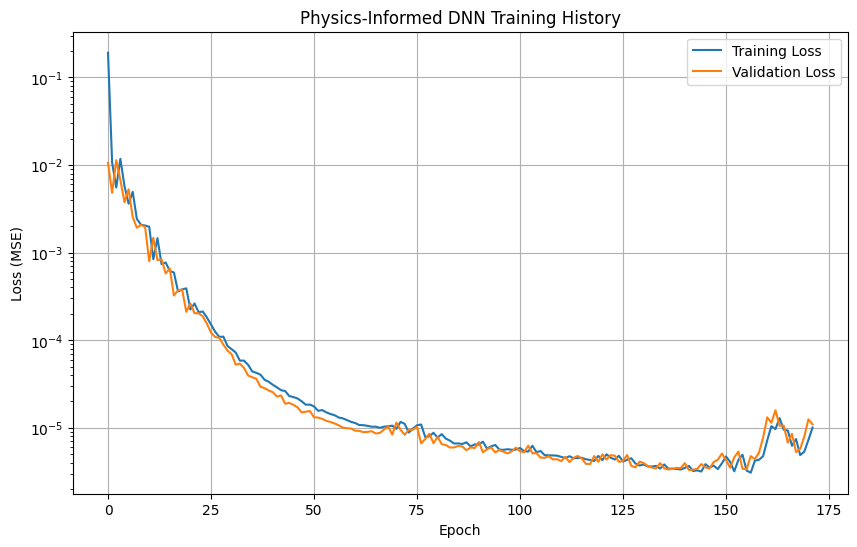


--- Model Prediction for UNSEEN (Interpolation) temperature (325 K) ---


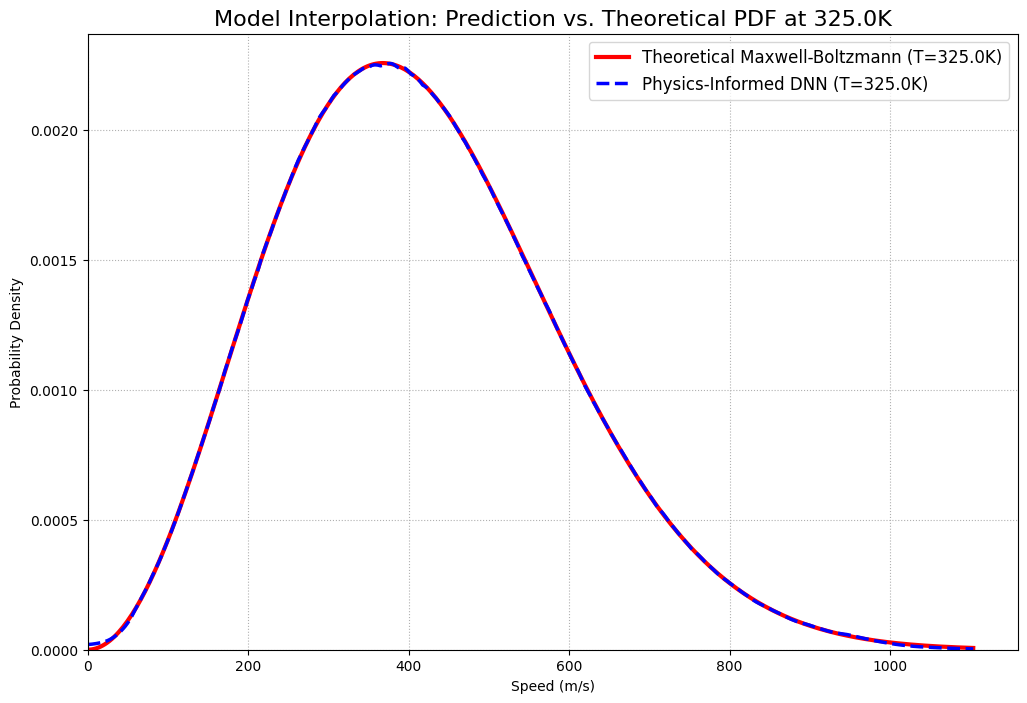


--- Model Prediction for SEEN temperature (500 K) ---


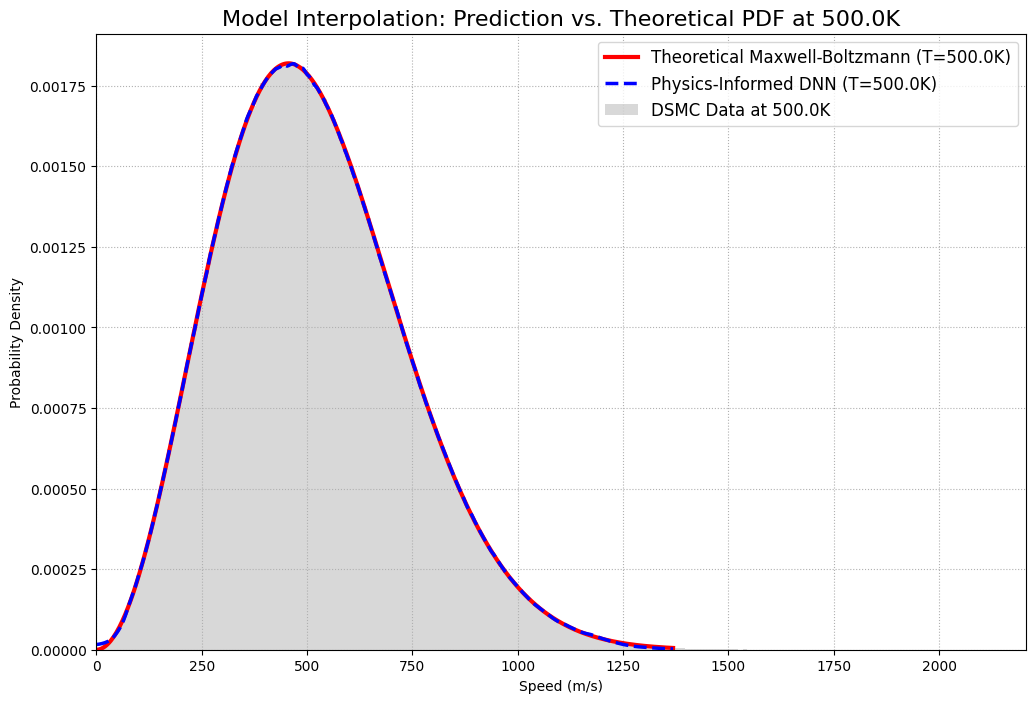


--- Model Prediction for UNSEEN (EXTRAPOLATION) temperature (900 K) ---


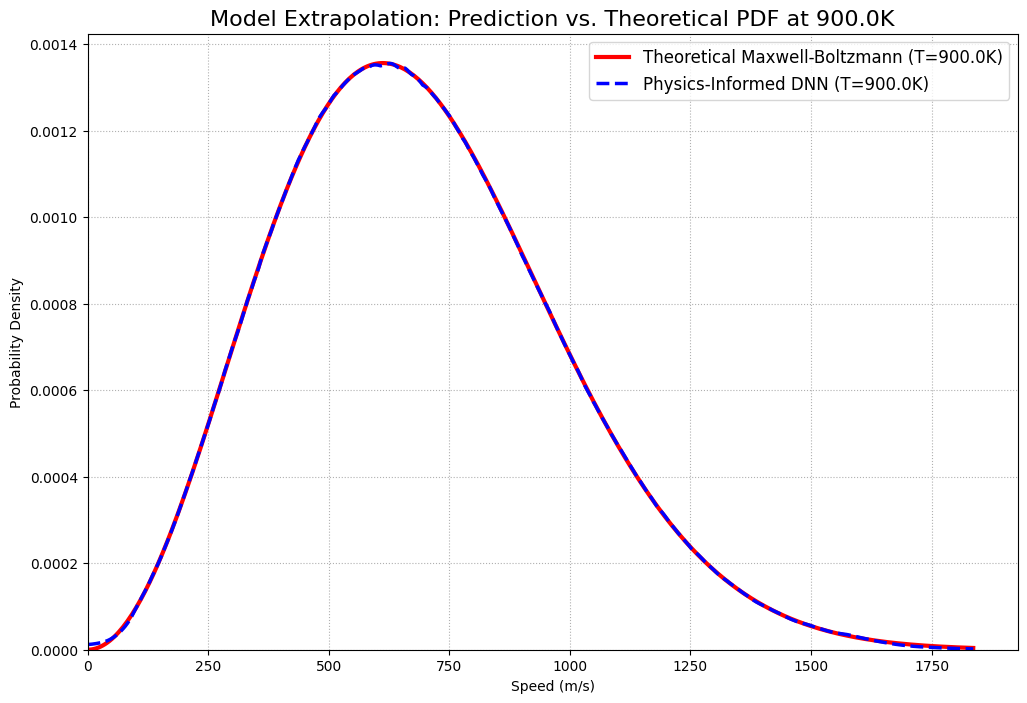

In [4]:
# ======================================================================
# FINAL ROBUST IMPLEMENTATION: Physics-Informed DNN
# This version uses physical scaling for robust extrapolation.
# ======================================================================

# --- Step 1: Imports and Setup ---
import numpy as np
import matplotlib.pyplot as plt
import numba
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow Version:", tf.__version__)
print("Numba Version:", numba.__version__)

# --- Step 2: DSMC Data Generation Function ---
# (Using the original, proven DSMC code - NO CHANGES HERE)

# Constants
MOLAR_MASS_AR = 39.948e-3; AVOGADRO_NUM = 6.022e23; MASS_AR = MOLAR_MASS_AR / AVOGADRO_NUM; KB = 1.380649e-23; D_REF_AR = 4.17e-10; T_REF_AR = 273.0; OMEGA_VHS = 0.81

@numba.jit(nopython=True)
def calculate_vhs_cross_section_numba(vr_mag):
    if vr_mag < 1e-9: return 1e-30
    exponent = OMEGA_VHS - 0.5; c_ref_sq = 2 * KB * T_REF_AR / MASS_AR; gamma_val = 1.04533
    d_sq = (D_REF_AR**2) * ((c_ref_sq / vr_mag**2)**exponent) * (1 / gamma_val)
    return np.pi * d_sq

@numba.jit(nopython=True)
def perform_collisions_in_cell_numba(particles, indices_in_cell, cell_vol, dt, fnum, sigma_vr_max):
    num_particles_in_cell = len(indices_in_cell)
    if num_particles_in_cell < 2: return
    num_candidate_pairs = (num_particles_in_cell * (num_particles_in_cell - 1) * fnum * sigma_vr_max * dt) / (2.0 * cell_vol)
    num_pairs_to_select = int(np.floor(num_candidate_pairs + np.random.rand()))
    for _ in range(num_pairs_to_select):
        idx1_local = np.random.randint(0, num_particles_in_cell)
        idx2_local = np.random.randint(0, num_particles_in_cell)
        while idx1_local == idx2_local: idx2_local = np.random.randint(0, num_particles_in_cell)
        p1_idx, p2_idx = indices_in_cell[idx1_local], indices_in_cell[idx2_local]
        vrx, vry, vrz = particles[p1_idx, 1] - particles[p2_idx, 1], particles[p1_idx, 2] - particles[p2_idx, 2], particles[p1_idx, 3] - particles[p2_idx, 3]
        vr_mag = np.sqrt(vrx**2 + vry**2 + vrz**2)
        if vr_mag < 1e-9: continue
        sigma_t = calculate_vhs_cross_section_numba(vr_mag)
        if np.random.rand() < (sigma_t * vr_mag) / sigma_vr_max:
            vcm_x, vcm_y, vcm_z = 0.5 * (particles[p1_idx, 1] + particles[p2_idx, 1]), 0.5 * (particles[p1_idx, 2] + particles[p2_idx, 2]), 0.5 * (particles[p1_idx, 3] + particles[p2_idx, 3])
            cos_chi = 2 * np.random.rand() - 1.0; sin_chi = np.sqrt(1.0 - cos_chi**2); phi_chi = 2.0 * np.pi * np.random.rand()
            vr_prime_x, vr_prime_y, vr_prime_z = vr_mag * sin_chi * np.cos(phi_chi), vr_mag * sin_chi * np.sin(phi_chi), vr_mag * cos_chi
            particles[p1_idx, 1:4] = vcm_x + 0.5 * vr_prime_x, vcm_y + 0.5 * vr_prime_y, vcm_z + 0.5 * vr_prime_z
            particles[p2_idx, 1:4] = vcm_x - 0.5 * vr_prime_x, vcm_y - 0.5 * vr_prime_y, vcm_z - 0.5 * vr_prime_z

def run_dsmc_simulation(target_temp, params):
    print(f"\n--- Running DSMC for T = {target_temp} K with '{params['name']}' settings ---")
    NUM_CELLS_X = params['num_cells']; PARTICLES_PER_CELL_INIT = params['particles_per_cell']; TOTAL_TIME = params['total_time']; SAMPLING_START_TIME = params['sampling_start']
    TOTAL_PARTICLES_SIM = NUM_CELLS_X * PARTICLES_PER_CELL_INIT; LX=1.0e-6; RHO_INIT=1.78
    N_DENSITY_REAL = RHO_INIT / MASS_AR; CELL_VOLUME_CONCEPTUAL = (LX**3) / NUM_CELLS_X
    FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT
    DT=1.0e-11; NUM_STEPS=int(TOTAL_TIME/DT); SAMPLING_START_STEP=int(SAMPLING_START_TIME/DT)
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4)); cell_width = LX / NUM_CELLS_X
    for i in range(NUM_CELLS_X):
        start_idx, end_idx = i * PARTICLES_PER_CELL_INIT, (i + 1) * PARTICLES_PER_CELL_INIT
        particles[start_idx:end_idx, 0] = i * cell_width + np.random.rand(PARTICLES_PER_CELL_INIT) * cell_width
    particles[:, 1:4] = 800.0 * (2.0 * np.random.rand(TOTAL_PARTICLES_SIM, 3) - 1.0)
    current_total_ke = 0.5 * MASS_AR * np.sum(particles[:, 1:4]**2); target_total_ke = 1.5 * TOTAL_PARTICLES_SIM * KB * target_temp
    scaling_factor = np.sqrt(target_total_ke / current_total_ke); particles[:, 1:4] *= scaling_factor
    vr_max_estimate = 10.0 * np.sqrt(KB * target_temp / MASS_AR); SIGMA_VR_MAX_GLOBAL = calculate_vhs_cross_section_numba(vr_max_estimate) * vr_max_estimate
    sampled_speeds_accumulator = []
    print(f"Starting simulation for {NUM_STEPS} steps...")
    for step in range(1, NUM_STEPS + 1):
        particles[:, 0] = (particles[:, 0] + particles[:, 1] * DT) % LX
        cell_indices = (particles[:, 0] / cell_width).astype(np.int64); sorted_particle_indices = np.argsort(cell_indices)
        cell_counts = np.bincount(cell_indices, minlength=NUM_CELLS_X); cell_start_indices = np.concatenate(([0], np.cumsum(cell_counts[:-1])))
        for i in range(NUM_CELLS_X):
            start, end = cell_start_indices[i], cell_start_indices[i] + cell_counts[i]
            perform_collisions_in_cell_numba(particles, sorted_particle_indices[start:end], CELL_VOLUME_CONCEPTUAL, DT, FNUM, SIGMA_VR_MAX_GLOBAL)
        if step >= SAMPLING_START_STEP: sampled_speeds_accumulator.extend(np.sqrt(np.sum(particles[:, 1:4]**2, axis=1)))
        if step % (NUM_STEPS // 4) == 0: print(f"      ... T={target_temp}K, Step {step}/{NUM_STEPS} completed ...")
    print(f"DSMC for T = {target_temp} K finished. Collected {len(sampled_speeds_accumulator)} samples.")
    return np.array(sampled_speeds_accumulator)

# --- Step 3: Physics-Informed Data Generation and Preprocessing ---
# (CHANGED) We now generate a dimensionless dataset.
simulation_params = {
    "name": "High Quality",
    "num_cells": 20,
    "particles_per_cell": 500,
    "total_time": 8.0e-7,
    "sampling_start": 4.0e-7,
}
training_temperatures = [200.0, 275.0, 350.0, 425.0, 500.0, 575.0, 650.0]
dsmc_results = {}
for temp in training_temperatures:
    dsmc_results[temp] = run_dsmc_simulation(target_temp=temp, params=simulation_params)

NUM_BINS = 200
X_train_list, y_train_list = [], []

print("\n--- Collapsing data onto a universal dimensionless curve ---")
for temp, speeds in dsmc_results.items():
    # Calculate characteristic speed for this temperature
    v_char = np.sqrt(KB * temp / MASS_AR)

    # Get histogram for physical speeds P(v) vs v
    hist, bin_edges = np.histogram(speeds, bins=NUM_BINS, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0 # These are the physical speeds 'v'

    # --- CHANGED: Convert to dimensionless variables ---
    # Convert physical speeds 'v' to dimensionless speeds 's'
    s_values = bin_centers / v_char
    # Convert probability density P(v) to dimensionless P(s)
    # P(s) = P(v) * dv/ds = P(v) * v_char
    Ps_values = hist * v_char

    X_train_list.extend(s_values)
    y_train_list.extend(Ps_values)

# Add the universal boundary condition: at s=0, P(s)=0
X_train_list.append(0.0)
y_train_list.append(0.0)

# Reshape for training
X_train = np.array(X_train_list).reshape(-1, 1)
y_train = np.array(y_train_list).reshape(-1, 1)

# Normalize the dimensionless data
x_mean, x_std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train_normalized = (X_train - x_mean) / x_std
y_max = np.max(y_train)
y_train_normalized = y_train / y_max

print(f"\nCreated a physics-informed training dataset with {len(X_train)} samples.")
print(f"All data is now on a single curve, independent of temperature.")


# --- Step 4: Define and Train the Physics-Informed DNN Model ---

# (CHANGED) Fourier Feature Layer is still useful for learning the universal curve shape
class FourierFeatureExpansion(layers.Layer):
    def __init__(self, num_fourier_features, scale=10.0, **kwargs):
        super().__init__(**kwargs)
        self.num_fourier_features = num_fourier_features
        self.scale = scale
        self.b_matrix = None

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.b_matrix = tf.random.normal(
            shape=(input_dim, self.num_fourier_features),
            mean=0.0,
            stddev=self.scale
        )
        super().build(input_shape)

    def call(self, x):
        x_proj = tf.matmul(x, self.b_matrix)
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- (CHANGED) Model architecture now takes a single input 's' ---
model = keras.Sequential([
    layers.Input(shape=(1,)), # Input is now 1D (dimensionless speed 's')
    FourierFeatureExpansion(num_fourier_features=128, scale=5.0), # Scale can be tuned
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='softplus') # softplus ensures non-negative P(s)
], name="Physics_Informed_DNN")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

# --- GPU Optimized Training ---
from sklearn.model_selection import train_test_split
BATCH_SIZE = 1024
SHUFFLE_BUFFER = 10000

X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_train_normalized, y_train_normalized, test_size=0.2, random_state=42
)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_np))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_np, y_val_np))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"\nCreated tf.data pipelines with batch size {BATCH_SIZE}.")
print("\nStarting Physics-Informed DNN model training...")
history = model.fit(
    train_dataset,
    epochs=300, # This simpler problem might converge faster
    validation_data=val_dataset,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    ]
)
print("Training finished.")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Physics-Informed DNN Training History'), plt.xlabel('Epoch'), plt.ylabel('Loss (MSE)')
plt.yscale('log'), plt.legend(), plt.grid(True), plt.show()


# --- Step 5: Evaluate the Final Model (Including EXTRAPOLATION) ---
# (CHANGED) The prediction function is now physics-informed.
def plot_final_prediction(test_temp, is_extrapolation=False):
    # --- 1. Define the physical speed range for plotting ---
    # We create a reasonable range for 'v' based on the test temperature
    v_peak_est = np.sqrt(2 * KB * test_temp / MASS_AR)
    v_test = np.linspace(0, v_peak_est * 3, 400) # Plot up to 3x the most probable speed

    # --- 2. Convert to dimensionless space for the NN ---
    v_char = np.sqrt(KB * test_temp / MASS_AR)
    s_test = v_test / v_char  # Our network's input

    nn_input = s_test.reshape(-1, 1)
    nn_input_normalized = (nn_input - x_mean) / x_std

    # --- 3. Get prediction from the model (in dimensionless space) ---
    predicted_Ps_normalized = model.predict(nn_input_normalized, verbose=0)
    predicted_Ps = predicted_Ps_normalized * y_max # Denormalize to get P(s)

    # --- 4. Convert the prediction back to physical space ---
    # P(v) = P(s) / v_char
    predicted_pdf = predicted_Ps.flatten() / v_char

    # --- 5. Calculate theoretical and plot ---
    theoretical_pdf = (4*np.pi*(MASS_AR/(2*np.pi*KB*test_temp))**1.5 * v_test**2 * np.exp(-MASS_AR*v_test**2/(2*KB*test_temp)))

    plt.figure(figsize=(12, 8))
    title_prefix = "Extrapolation" if is_extrapolation else "Interpolation"
    plt.plot(v_test, theoretical_pdf, 'r-', linewidth=3, label=f'Theoretical Maxwell-Boltzmann (T={test_temp}K)')
    plt.plot(v_test, predicted_pdf, 'b--', linewidth=2.5, label=f'Physics-Informed DNN (T={test_temp}K)')

    # Plot the original DSMC data for comparison if available
    if test_temp in dsmc_results:
        plt.hist(dsmc_results[test_temp], bins=NUM_BINS, density=True, color='gray', alpha=0.3, label=f'DSMC Data at {test_temp}K')

    plt.title(f'Model {title_prefix}: Prediction vs. Theoretical PDF at {test_temp}K', fontsize=16)
    plt.xlabel('Speed (m/s)'), plt.ylabel('Probability Density'), plt.legend(fontsize=12)
    plt.grid(True, linestyle=':'), plt.xlim(left=0), plt.ylim(bottom=0), plt.show()

# --- ارزیابی نهایی ---
print("\n--- Model Prediction for UNSEEN (Interpolation) temperature (325 K) ---")
plot_final_prediction(325.0, is_extrapolation=False)

print("\n--- Model Prediction for SEEN temperature (500 K) ---")
plot_final_prediction(500.0, is_extrapolation=False)

# =================================================================
#           ✨ تست اصلی: ارزیابی توانایی برون‌یابی مدل ✨
# =================================================================
# مدل روی منحنی جهانی آموزش دیده است. اکنون آن را برای دمای بسیار بالاتر تست می‌کنیم.
print("\n--- Model Prediction for UNSEEN (EXTRAPOLATION) temperature (900 K) ---")
plot_final_prediction(900.0, is_extrapolation=True)

TensorFlow Version: 2.18.0
Numba Version: 0.60.0

--- Running DSMC for T = 200.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
      ... T=200.0K, Step 20000/80000 completed ...
      ... T=200.0K, Step 40000/80000 completed ...
      ... T=200.0K, Step 60000/80000 completed ...
      ... T=200.0K, Step 80000/80000 completed ...
DSMC for T = 200.0 K finished. Collected 400010000 samples.

--- Running DSMC for T = 275.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
      ... T=275.0K, Step 20000/80000 completed ...
      ... T=275.0K, Step 40000/80000 completed ...
      ... T=275.0K, Step 60000/80000 completed ...
      ... T=275.0K, Step 80000/80000 completed ...
DSMC for T = 275.0 K finished. Collected 400010000 samples.

--- Running DSMC for T = 350.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
      ... T=350.0K, Step 20000/80000 completed ...
      ... T=350.0K, Step 40000/80000 completed ...
   

Model: "Regularized_DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,569 (1.76 MB)

 Trainable params: 461,569 (1.76 MB)

 Non-trainable params: 0 (0.00 B)


Created tf.data pipelines with batch size 1024.

Starting regularized model training...
Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 0.3232 - val_loss: 0.1502 - learning_rate: 0.0010
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1498 - val_loss: 0.0939 - learning_rate: 0.0010
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0873 - val_loss: 0.0962 - learning_rate: 0.0010
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0843 - val_loss: 0.0976 - learning_rate: 0.0010
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0846 - val_loss: 0.0898 - learning_rate: 0.0010
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0793 - val_loss: 0.0759 - learning_rate: 0.0010
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0692 - val_loss: 0.0613 - learning_rate: 0.0010
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0562 - val_loss: 0.0516 - learning_rate: 0.0010
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/s

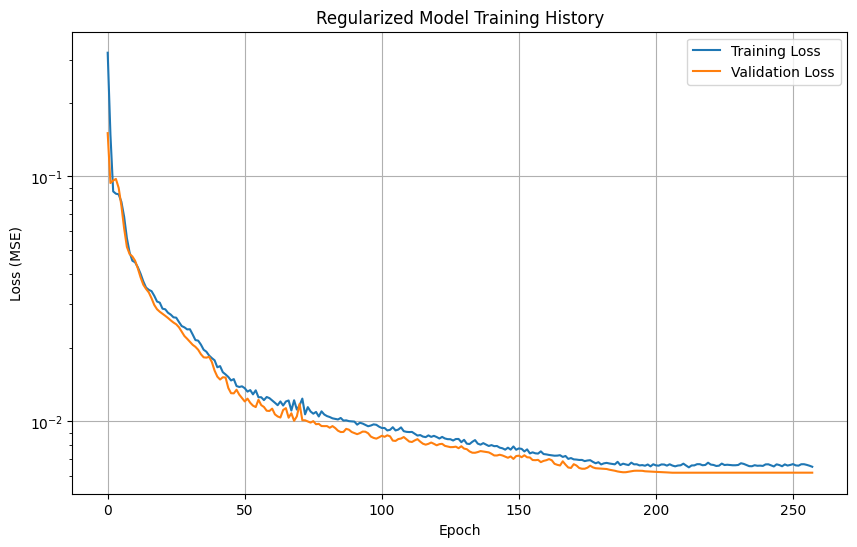


--- Final Model Prediction for an UNSEEN temperature (325 K) ---


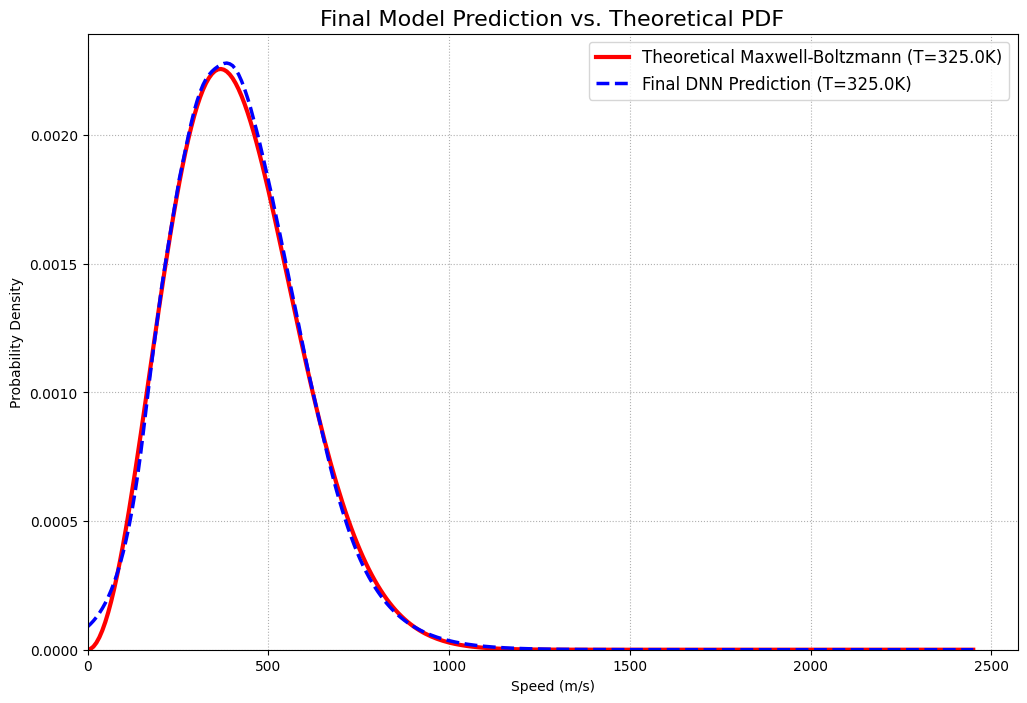


--- Final Model Prediction for a SEEN temperature (500 K) ---


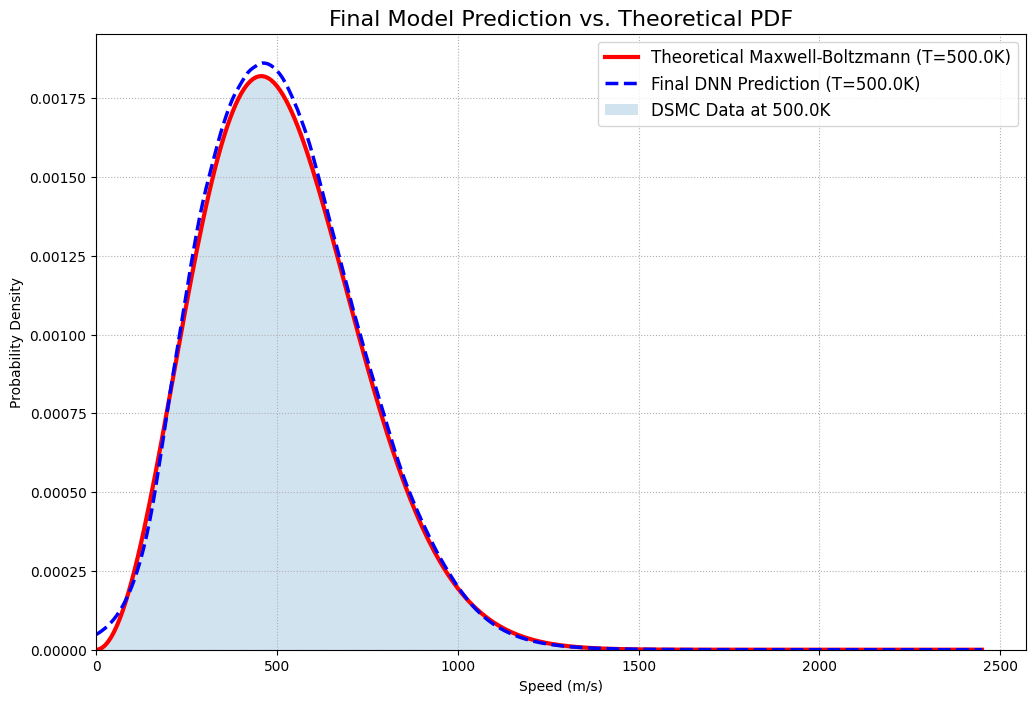

In [5]:
# ======================================================================
# FINAL ROBUST IMPLEMENTATION: Regularized Supervised DNN
# This version is optimized for stable training and better generalization.
# ======================================================================

# --- Step 1: Imports and Setup ---
import numpy as np
import matplotlib.pyplot as plt
import numba
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2 # CHANGED: Import l2 regularizer

print("TensorFlow Version:", tf.__version__)
print("Numba Version:", numba.__version__)

# --- Step 2: DSMC Data Generation Function ---
# (NO CHANGES HERE - This section remains the same)

# Constants
MOLAR_MASS_AR = 39.948e-3; AVOGADRO_NUM = 6.022e23; MASS_AR = MOLAR_MASS_AR / AVOGADRO_NUM; KB = 1.380649e-23; D_REF_AR = 4.17e-10; T_REF_AR = 273.0; OMEGA_VHS = 0.81

@numba.jit(nopython=True)
def calculate_vhs_cross_section_numba(vr_mag):
    if vr_mag < 1e-9: return 1e-30
    exponent = OMEGA_VHS - 0.5; c_ref_sq = 2 * KB * T_REF_AR / MASS_AR; gamma_val = 1.04533
    d_sq = (D_REF_AR**2) * ((c_ref_sq / vr_mag**2)**exponent) * (1 / gamma_val)
    return np.pi * d_sq

@numba.jit(nopython=True)
def perform_collisions_in_cell_numba(particles, indices_in_cell, cell_vol, dt, fnum, sigma_vr_max):
    num_particles_in_cell = len(indices_in_cell)
    if num_particles_in_cell < 2: return
    num_candidate_pairs = (num_particles_in_cell * (num_particles_in_cell - 1) * fnum * sigma_vr_max * dt) / (2.0 * cell_vol)
    num_pairs_to_select = int(np.floor(num_candidate_pairs + np.random.rand()))
    for _ in range(num_pairs_to_select):
        idx1_local = np.random.randint(0, num_particles_in_cell)
        idx2_local = np.random.randint(0, num_particles_in_cell)
        while idx1_local == idx2_local: idx2_local = np.random.randint(0, num_particles_in_cell)
        p1_idx, p2_idx = indices_in_cell[idx1_local], indices_in_cell[idx2_local]
        vrx, vry, vrz = particles[p1_idx, 1] - particles[p2_idx, 1], particles[p1_idx, 2] - particles[p2_idx, 2], particles[p1_idx, 3] - particles[p2_idx, 3]
        vr_mag = np.sqrt(vrx**2 + vry**2 + vrz**2)
        if vr_mag < 1e-9: continue
        sigma_t = calculate_vhs_cross_section_numba(vr_mag)
        if np.random.rand() < (sigma_t * vr_mag) / sigma_vr_max:
            vcm_x, vcm_y, vcm_z = 0.5 * (particles[p1_idx, 1] + particles[p2_idx, 1]), 0.5 * (particles[p1_idx, 2] + particles[p2_idx, 2]), 0.5 * (particles[p1_idx, 3] + particles[p2_idx, 3])
            cos_chi = 2 * np.random.rand() - 1.0; sin_chi = np.sqrt(1.0 - cos_chi**2); phi_chi = 2.0 * np.pi * np.random.rand()
            vr_prime_x, vr_prime_y, vr_prime_z = vr_mag * sin_chi * np.cos(phi_chi), vr_mag * sin_chi * np.sin(phi_chi), vr_mag * cos_chi
            particles[p1_idx, 1:4] = vcm_x + 0.5 * vr_prime_x, vcm_y + 0.5 * vr_prime_y, vcm_z + 0.5 * vr_prime_z
            particles[p2_idx, 1:4] = vcm_x - 0.5 * vr_prime_x, vcm_y - 0.5 * vr_prime_y, vcm_z - 0.5 * vr_prime_z

def run_dsmc_simulation(target_temp, params):
    print(f"\n--- Running DSMC for T = {target_temp} K with '{params['name']}' settings ---")
    NUM_CELLS_X = params['num_cells']; PARTICLES_PER_CELL_INIT = params['particles_per_cell']; TOTAL_TIME = params['total_time']; SAMPLING_START_TIME = params['sampling_start']
    TOTAL_PARTICLES_SIM = NUM_CELLS_X * PARTICLES_PER_CELL_INIT; LX=1.0e-6; RHO_INIT=1.78
    N_DENSITY_REAL = RHO_INIT / MASS_AR; CELL_VOLUME_CONCEPTUAL = (LX**3) / NUM_CELLS_X
    FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT
    DT=1.0e-11; NUM_STEPS=int(TOTAL_TIME/DT); SAMPLING_START_STEP=int(SAMPLING_START_TIME/DT)
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4)); cell_width = LX / NUM_CELLS_X
    for i in range(NUM_CELLS_X):
        start_idx, end_idx = i * PARTICLES_PER_CELL_INIT, (i + 1) * PARTICLES_PER_CELL_INIT
        particles[start_idx:end_idx, 0] = i * cell_width + np.random.rand(PARTICLES_PER_CELL_INIT) * cell_width
    particles[:, 1:4] = 800.0 * (2.0 * np.random.rand(TOTAL_PARTICLES_SIM, 3) - 1.0)
    current_total_ke = 0.5 * MASS_AR * np.sum(particles[:, 1:4]**2); target_total_ke = 1.5 * TOTAL_PARTICLES_SIM * KB * target_temp
    scaling_factor = np.sqrt(target_total_ke / current_total_ke); particles[:, 1:4] *= scaling_factor
    vr_max_estimate = 10.0 * np.sqrt(KB * target_temp / MASS_AR); SIGMA_VR_MAX_GLOBAL = calculate_vhs_cross_section_numba(vr_max_estimate) * vr_max_estimate
    sampled_speeds_accumulator = []
    print(f"Starting simulation for {NUM_STEPS} steps...")
    for step in range(1, NUM_STEPS + 1):
        particles[:, 0] = (particles[:, 0] + particles[:, 1] * DT) % LX
        cell_indices = (particles[:, 0] / cell_width).astype(np.int64); sorted_particle_indices = np.argsort(cell_indices)
        cell_counts = np.bincount(cell_indices, minlength=NUM_CELLS_X); cell_start_indices = np.concatenate(([0], np.cumsum(cell_counts[:-1])))
        for i in range(NUM_CELLS_X):
            start, end = cell_start_indices[i], cell_start_indices[i] + cell_counts[i]
            perform_collisions_in_cell_numba(particles, sorted_particle_indices[start:end], CELL_VOLUME_CONCEPTUAL, DT, FNUM, SIGMA_VR_MAX_GLOBAL)
        if step >= SAMPLING_START_STEP: sampled_speeds_accumulator.extend(np.sqrt(np.sum(particles[:, 1:4]**2, axis=1)))
        if step % (NUM_STEPS // 4) == 0: print(f"      ... T={target_temp}K, Step {step}/{NUM_STEPS} completed ...")
    print(f"DSMC for T = {target_temp} K finished. Collected {len(sampled_speeds_accumulator)} samples.")
    return np.array(sampled_speeds_accumulator)

# --- Step 3: High-Quality Data Generation and Preprocessing ---
# (NO CHANGES HERE - This section remains the same)
simulation_params = {
    "name": "High Quality",
    "num_cells": 20,
    "particles_per_cell": 500,
    "total_time": 8.0e-7,
    "sampling_start": 4.0e-7,
}
training_temperatures = [200.0, 275.0, 350.0, 425.0, 500.0, 575.0, 650.0]
dsmc_results = {}
for temp in training_temperatures:
    dsmc_results[temp] = run_dsmc_simulation(target_temp=temp, params=simulation_params)

NUM_BINS = 200
X_train_list, y_train_list = [], []
for temp, speeds in dsmc_results.items():
    hist, bin_edges = np.histogram(speeds, bins=NUM_BINS, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    for i in range(len(bin_centers)):
        X_train_list.append([bin_centers[i], temp])
        y_train_list.append(hist[i])
print("\nInjecting physical boundary condition (v=0, P=0)...")
for temp in training_temperatures:
    X_train_list.append([0.0, temp])
    y_train_list.append(0.0)
X_train, y_train = np.array(X_train_list), np.array(y_train_list)
x_mean, x_std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train_normalized = (X_train - x_mean) / x_std
y_max = np.max(y_train)
y_train_normalized = y_train / y_max
print(f"\nCreated a high-quality training dataset with {len(X_train)} samples.")


# --- Step 4: Define and Train the Regularized DNN Model ---

# --- CHANGED: Added L2 Regularization and Dropout to the model ---
L2_LAMBDA = 1e-5  # A small value for the regularization penalty
model = keras.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(512, activation='relu', kernel_regularizer=l2(L2_LAMBDA)),
    layers.Dropout(0.3), # Dropout layer with a 30% rate
    layers.Dense(512, activation='relu', kernel_regularizer=l2(L2_LAMBDA)),
    layers.Dropout(0.3), # Dropout layer with a 30% rate
    layers.Dense(256, activation='relu', kernel_regularizer=l2(L2_LAMBDA)),
    layers.Dropout(0.2), # Lower dropout rate for smaller layers
    layers.Dense(256, activation='relu', kernel_regularizer=l2(L2_LAMBDA)),
    layers.Dense(1, activation='softplus') # No regularization on the output layer
], name="Regularized_DNN")

# Using the Adam optimizer with a default learning rate
# The Learning Rate Scheduler will handle adjustments
model.compile(optimizer=keras.optimizers.Adam(), loss='mean_squared_error')
model.summary()


# --- CHANGED: Added Learning Rate Scheduler ---
# This creates a highly efficient data pipeline that feeds the GPU without bottlenecks.
BATCH_SIZE = 1024
SHUFFLE_BUFFER = 10000

# Create training and validation datasets
from sklearn.model_selection import train_test_split
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_train_normalized, y_train_normalized, test_size=0.2, random_state=42
)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_np))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_np, y_val_np))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"\nCreated tf.data pipelines with batch size {BATCH_SIZE}.")

# Define the callbacks for training
callbacks_list = [
    # Stop training early if validation loss doesn't improve for 50 epochs
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True
    ),
    # Reduce learning rate if validation loss plateaus for 10 epochs
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2, # Reduce LR by a factor of 5
        patience=10,
        verbose=1,
        min_lr=1e-7 # Don't reduce LR below this value
    )
]

print("\nStarting regularized model training...")
history = model.fit(
    train_dataset,
    epochs=500, # Max epochs, EarlyStopping will likely stop it sooner
    validation_data=val_dataset,
    verbose=1,
    callbacks=callbacks_list # Use the list of callbacks
)
print("Training finished.")

# Plotting the training history will now show a much smoother validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Regularized Model Training History'), plt.xlabel('Epoch'), plt.ylabel('Loss (MSE)')
plt.yscale('log'), plt.legend(), plt.grid(True), plt.show()


# --- Step 5: Evaluate the Final Model ---
# (NO CHANGES HERE - This section remains the same)
def plot_final_prediction(test_temp):
    max_speed_in_data = np.max([np.max(s) for s in dsmc_results.values()])
    v_test = np.linspace(0, max_speed_in_data * 1.1, 300)
    nn_input = np.stack([v_test, np.full_like(v_test, test_temp)], axis=-1)
    nn_input_normalized = (nn_input - x_mean) / x_std
    predicted_pdf_normalized = model.predict(nn_input_normalized, verbose=0)
    predicted_pdf = predicted_pdf_normalized * y_max
    theoretical_pdf = (4*np.pi*(MASS_AR/(2*np.pi*KB*test_temp))**1.5 * v_test**2 * np.exp(-MASS_AR*v_test**2/(2*KB*test_temp)))
    plt.figure(figsize=(12, 8))
    plt.plot(v_test, theoretical_pdf, 'r-', linewidth=3, label=f'Theoretical Maxwell-Boltzmann (T={test_temp}K)')
    plt.plot(v_test, predicted_pdf, 'b--', linewidth=2.5, label=f'Final DNN Prediction (T={test_temp}K)')
    if test_temp in dsmc_results:
        plt.hist(dsmc_results[test_temp], bins=NUM_BINS, density=True, alpha=0.2, label=f'DSMC Data at {test_temp}K')
    plt.title(f'Final Model Prediction vs. Theoretical PDF', fontsize=16)
    plt.xlabel('Speed (m/s)'), plt.ylabel('Probability Density'), plt.legend(fontsize=12)
    plt.grid(True, linestyle=':'), plt.xlim(left=0), plt.ylim(bottom=0), plt.show()

print("\n--- Final Model Prediction for an UNSEEN temperature (325 K) ---")
plot_final_prediction(325.0)
print("\n--- Final Model Prediction for a SEEN temperature (500 K) ---")
plot_final_prediction(500.0)